<a href="https://colab.research.google.com/github/andres-merino/FormatoBaseProyectos/blob/main/Plantilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="border: none; border-collapse: collapse;">
    <tr>
        <td style="width: 20%; vertical-align: middle; padding-right: 10px;">
            <img src="https://i.imgur.com/nt7hloA.png" width="100">
        </td>
        <td style="width: 2px; text-align: center;">
            <font color="#0030A1" size="7">|</font><br>
            <font color="#0030A1" size="7">|</font>
        </td>
        <td>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="5">
                <b>Carrera de Ciencia de Datos</b>
            </font> </p>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="4">
                Asignatura &bull; Tema
            </font></p>
            <p style="font-style: oblique;"><font color="#0030A1" size="3">
                Andrés Merino &bull; 2025-01
            </font></p>
        </td>  
    </tr>
</table>

---
## <font color='264CC7'> Introducción </font>

#### <font color='022257'> Contextualización del problema y objetivos </font>


La infección por Trypanosoma cruzi es una enfermedad de alto impacto en salud pública, ya que puede generar secuelas graves a largo plazo, incluyendo compromiso cardíaco, neurológico y, en casos avanzados, la muerte. Dada la diversidad de especies que actúan como vectores y la complejidad de su control, la prevención y la identificación temprana de condiciones de riesgo en las viviendas constituyen las estrategias más efectivas para reducir la transmisión.

En este contexto, el presente estudio se centra en el análisis del dataset Vivienda Loja 2005, obtenido a partir de una encuesta aplicada en diferentes viviendas de la ciudad de Loja, que incluye hogares con resultados epidemiológicos tanto positivos como negativos para Chagas. Este conjunto de datos ofrece una oportunidad única para analizar, desde un enfoque integral, las características estructurales, ambientales y peridomiciliarias asociadas a la presencia del vector.

**Objetivo general**

Identificar y caracterizar los perfiles de viviendas que presentan condiciones favorables para la presencia del vector del Chagas, y visualizarlos de manera clara para apoyar la toma de decisiones e intervenciones en salud pública.

**Objetivos específicos**

Explorar el contenido de la encuesta para comprender el significado de cada ítem y el tipo de variables disponibles (numéricas o categóricas).

Identificar y seleccionar las variables más relevantes para la investigación, incluyendo la variable epidemiológica, que permitan describir adecuadamente los perfiles de vivienda.

Realizar procesos de limpieza y tratamiento de datos, incluyendo el manejo de valores faltantes, para garantizar la calidad del análisis.

Aplicar y comparar distintas técnicas de clustering, con el fin de enriquecer la investigación y aprovechar las fortalezas de cada algoritmo en la identificación de viviendas de alto riesgo.

Caracterizar los grupos obtenidos a partir de sus variables predominantes y cruzarlos con la información epidemiológica para identificar los clusters con mayor carga de casos positivos.

Visualizar los clusters de forma informativa, intuitiva y accesible, facilitando su interpretación por equipos técnicos y tomadores de decisión.

Interpretar los resultados de manera clara y concisa, destacando los hallazgos más relevantes para la salud pública.

Proponer recomendaciones orientadas a la continuidad de la investigación y al diseño de estrategias preventivas y de intervención focalizada.

#### <font color='022257'> Breve descripción de las técnicas utilizadas  </font>

El dataset mezcla preguntas binarias (sí/no) y preguntas categóricas en one-hot. Por eso usamos distintos métodos de clustering según el tipo de variable y la métrica más adecuada.

Clustering jerárquico (Hamming)
Usamos variables binarias (0/1). Hamming mide cuántas respuestas difieren entre viviendas, ideal para patrones sí/no.

K-Means (Euclídea)
Usamos variables one-hot (0/1). K-Means funciona en espacio euclídeo y permite obtener centroides interpretables como “perfil promedio” de vivienda.

DBSCAN (Jaccard)
Usamos binarias + one-hot juntas. Jaccard da más peso a coincidencias en “1” (presencia), útil cuando hay muchos “0”. DBSCAN además detecta grupos densos y separa casos atípicos como ruido.

Lo realizamos así para poder tener una investigación robusta y tomar lo mejor de cada método.



Los paquetes necesarios son:

In [2]:
import numpy as np
import pandas as pd

import re
import unicodedata
import umap

import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


---
## <font color='264CC7'> Lectura y transformación inicial </font>


#### <font color='022257'> Carga, selección y limpieza inicial del dataset  </font>

Se carga el archivo CSV desde una URL.
Se seleccionan solo las columnas de interés (por prefijos A, B, C, D, E, F) más el código de vivienda y el estado entomológico.
Se normalizan los nombres de columnas a formato simple (snake_case).
Se limpian los valores para que las respuestas queden en estándar 0/1 (sí/no) y A3 quede como numérica.
Se crean variables “sin_respuesta” para grupos tipo one-hot (A5/A6/A7) cuando nadie marcó opción.
Y se reportan columnas constantes para decidir si eliminarlas después.



In [3]:
PATH = "https://raw.githubusercontent.com/arellysoria/tareas-machine-learning-puce/refs/heads/main/Viviendas_Loja_2005%20(1).csv"

try:
    df_raw = pd.read_csv(PATH, encoding="utf-8", low_memory=False)
except UnicodeDecodeError:

    df_raw = pd.read_csv(PATH, encoding="latin-1", low_memory=False)

wanted_prefixes = [
    "A1","A3","A5","A6","A7","A8",
    "B1","B2","B3",
    "C1","C2",
    "D1","D2",
    "E1","E2","E3","E4","E10",
    "F1","F2","F3"
]

def matches_prefix(col: str, prefix: str) -> bool:

    return re.match(rf"^{re.escape(prefix)}(\b|\.|\s|_)", col.strip(), flags=re.IGNORECASE) is not None

cols = list(df_raw.columns)


id_cols = [c for c in cols if c.strip().lower() in ["código", "codigo", "codigo_vivienda", "id", "código_vivienda"]]
status_cols = [c for c in cols if c.strip().lower() == "status entomologico"]

keep = []
keep += id_cols
keep += status_cols
for p in wanted_prefixes:
    keep += [c for c in cols if matches_prefix(c, p)]

keep = list(dict.fromkeys(keep))

df = df_raw[keep].copy()

# normalizcion de columnas
def to_snake(s: str) -> str:
    s = s.strip()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

df.columns = [to_snake(c) for c in df.columns]

# normalizacion nombres
for c in list(df.columns):
    if c in ["codigo", "codigo_vivienda", "codigo_vivienda_"]:
        df = df.rename(columns={c: "codigo_vivienda"})
    if c in ["status_entomologico", "status_entomologico_"]:
        df = df.rename(columns={c: "status_entomologico"})

def strip_accents_lower(x: str) -> str:
    x = unicodedata.normalize("NFKD", x)
    x = "".join(ch for ch in x if not unicodedata.combining(ch))
    return x.strip().lower()

TRUE_SET  = {"1","si","sí","s","true","verdadero","v","x","checked","marcado"}
FALSE_SET = {"0","no","false","falso","n","none","nan",""}

def to_binary(x):
    """Convierte mezclas tipo True/False, 'VERDADERO/FALSO', 'SI/NO', '1/2' a 1/0.
       Devuelve NaN si no puede interpretarlo."""
    if pd.isna(x):
        return np.nan

    # bool directo
    if isinstance(x, (bool, np.bool_)):
        return 1 if x else 0

    # numerico directo
    if isinstance(x, (int, np.integer)):
        if x == 1: return 1
        if x == 0: return 0
        if x == 2: return 0  # típico 1=si, 2=no
        return np.nan

    if isinstance(x, (float, np.floating)):
        if np.isnan(x): return np.nan
        if x == 1.0: return 1
        if x == 0.0: return 0
        if x == 2.0: return 0
        return np.nan

    # texto
    s = strip_accents_lower(str(x))
    if s in TRUE_SET:  return 1
    if s in FALSE_SET: return 0

    # digitos
    if s.isdigit():
        n = int(s)
        if n == 1: return 1
        if n == 0: return 0
        if n == 2: return 0
    return np.nan

# A3 numerica
a3_cols = [c for c in df.columns if c.startswith("a3")]
for c in a3_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

exclude = {"codigo_vivienda", "status_entomologico"} | set(a3_cols)
binary_cols = [c for c in df.columns if c not in exclude]

for c in binary_cols:
    df[c] = df[c].map(to_binary)

# 0/1/NA
def is_binary_series(s: pd.Series) -> bool:
    vals = set(s.dropna().unique().tolist())
    return vals.issubset({0, 1})

for c in binary_cols:
    if is_binary_series(df[c]):
        df[c] = df[c].astype("Int64")

# variables "sin_respuesta" para A5/A6/A7
def add_sin_respuesta(prefix: str, new_name: str):
    cols_group = [c for c in df.columns if c.startswith(prefix)]
    if cols_group:
        df[new_name] = (df[cols_group].fillna(0).sum(axis=1) == 0).astype("Int64")

add_sin_respuesta("a5_", "a5_sin_respuesta")
add_sin_respuesta("a6_", "a6_sin_respuesta")
add_sin_respuesta("a7_", "a7_sin_respuesta")

const_cols = [c for c in df.columns if df[c].nunique(dropna=True) <= 1]
print("Shape final:", df.shape)
print("Columnas constantes", const_cols)

# df
df.head()

Shape final: (1000, 60)
Columnas constantes ['c1_lugares', 'c2_lugares']


,codigo_vivienda,status_entomologico,a1_tiene_luz_electrica,a3_numero_de_personas_que_duermen_en_la_vivienda,a5_escusado_de_uso_exclusivo_del_hogar,a5_escusado_de_uso_comun_de_varios_hogares,a5_letrina,a5_no_tiene,a6_red_publica_de_alcantarillado,a6_pozo_ciego,...,e3_cuantos,e4_duerme_el_perro_dentro_de_la_casa,e10_gatos,e10_cuantos,f1_ratones,f2_ratas,f3_raposas_zorros_guanchacas_o_zarigueyas,a5_sin_respuesta,a6_sin_respuesta,a7_sin_respuesta
0,AB007,Negativa,1,5.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,AB207,Negativa,1,1.0,0,1,0,0,0,1,...,0,0,0,0,1,1,1,0,0,0
2,AB208,Negativa,1,5.0,1,0,0,0,0,0,...,0,0,0,0,<NA>,<NA>,0,0,0,0
3,AB209,Negativa,1,3.0,0,0,0,1,0,0,...,0,0,0,0,<NA>,<NA>,0,0,0,0
4,AB210,Negativa,1,10.0,1,0,0,0,0,0,...,0,0,0,0,<NA>,<NA>,0,0,0,0


#### <font color='022257'> Limpieza de datos para trabajar con datos en one hot (K means)  y binarios (Clustering Jerarquico Aglomerativo ) </font>

Aquí se estandarizan las respuestas del dataset: A3 se convierte a numérica, las variables sí/no se transforman a 0/1 aunque vengan como texto o códigos, y F1–F3 (frecuencia) se limpian y se pasan a one-hot con una marca de “sin respuesta”. Además, se crean indicadores de “sin respuesta” para A5/A6/A7 y se detectan columnas constantes para posible eliminación.



In [4]:
def strip_accents_lower(x: str) -> str:
    x = unicodedata.normalize("NFKD", x)
    x = "".join(ch for ch in x if not unicodedata.combining(ch))
    return x.strip().lower()

TRUE_SET  = {"1","si","sí","s","true","verdadero","v","x","checked","marcado"}
FALSE_SET = {"0","no","false","falso","n","none","nan",""}

def to_binary(x):
    if pd.isna(x):
        return np.nan

    if isinstance(x, (bool, np.bool_)):
        return 1 if x else 0

    if isinstance(x, (int, np.integer)):
        if x == 1: return 1
        if x == 0: return 0
        if x == 2: return 0  # típico 1=si, 2=no
        return np.nan

    if isinstance(x, (float, np.floating)):
        if np.isnan(x): return np.nan
        if x == 1.0: return 1
        if x == 0.0: return 0
        if x == 2.0: return 0
        return np.nan

    s = strip_accents_lower(str(x))
    if s in TRUE_SET:  return 1
    if s in FALSE_SET: return 0

    if s.isdigit():
        n = int(s)
        if n == 1: return 1
        if n == 0: return 0
        if n == 2: return 0
    return np.nan

a3_cols = [c for c in df.columns if c.startswith("a3")]
for c in a3_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

ORDINAL_F_COLS = [
    "f1_ratones",
    "f2_ratas",
    "f3_raposas_zorros_guanchacas_o_zarigueyas"
]
ORDINAL_F_COLS = [c for c in ORDINAL_F_COLS if c in df.columns]  # por si alguna no existe

def to_ordinal_0_4(x):
    if pd.isna(x):
        return np.nan
    # si viene como int
    if isinstance(x, (int, np.integer, float, np.floating)):
        if pd.isna(x):
            return np.nan
        xi = int(x)
        return xi if xi in (0,1,2,3,4) else np.nan

    s = strip_accents_lower(str(x))

    # casos comunes, 0, 1, ..., 4
    if s.isdigit():
        xi = int(s)
        return xi if xi in (0,1,2,3,4) else np.nan

    # si en la encuesta a veces viene texto (por si acaso)
    mapping_text = {
        "nunca": 1,
        "rara vez": 2,
        "raravez": 2,
        "frecuentemente": 3,
        "siempre": 4,
        "todo el tiempo": 4,
        "todo_el_tiempo": 4
    }
    return mapping_text.get(s, np.nan)

for c in ORDINAL_F_COLS:
    df[c] = df[c].map(to_ordinal_0_4).astype("Int64")


# binarias
exclude = {"codigo_vivienda", "status_entomologico"} | set(a3_cols) | set(ORDINAL_F_COLS)
binary_cols = [c for c in df.columns if c not in exclude]

for c in binary_cols:
    df[c] = df[c].map(to_binary)

def is_binary_series(s: pd.Series) -> bool:
    vals = set(s.dropna().unique().tolist())
    return vals.issubset({0, 1})

for c in binary_cols:
    if is_binary_series(df[c]):
        df[c] = df[c].astype("Int64")


# one-hot para F1/F2/F3 (1..4)
F_LABELS = {
    1: "nunca",
    2: "rara_vez",
    3: "frecuentemente",
    4: "siempre"
}

for c in ORDINAL_F_COLS:
    base = c
    df[f"{base}_sin_respuesta"] = (df[c].isna() | (df[c] == 0)).astype("Int64")

    # one-hot 1..4
    for val, lab in F_LABELS.items():
        df[f"{base}_{lab}"] = (df[c] == val).astype("Int64")

    df.drop(columns=[c], inplace=True)

# "sin_respuesta" para A5/A6/A7

def add_sin_respuesta(prefix: str, new_name: str):
    cols_group = [c for c in df.columns if c.startswith(prefix)]
    if cols_group:
        df[new_name] = (df[cols_group].fillna(0).sum(axis=1) == 0).astype("Int64")

add_sin_respuesta("a5_", "a5_sin_respuesta")
add_sin_respuesta("a6_", "a6_sin_respuesta")
add_sin_respuesta("a7_", "a7_sin_respuesta")

# Visualización de columnas constantes

const_cols = [c for c in df.columns if df[c].nunique(dropna=True) <= 1]
print("Shape final:", df.shape)
print("Columnas constantes:", const_cols)

df.head()


Shape final: (1000, 72)
Columnas constantes: ['c1_lugares', 'c2_lugares', 'a5_sin_respuesta', 'a6_sin_respuesta', 'a7_sin_respuesta', 'f1_ratones_rara_vez', 'f1_ratones_frecuentemente', 'f1_ratones_siempre', 'f2_ratas_rara_vez', 'f2_ratas_frecuentemente', 'f2_ratas_siempre', 'f3_raposas_zorros_guanchacas_o_zarigueyas_rara_vez', 'f3_raposas_zorros_guanchacas_o_zarigueyas_frecuentemente', 'f3_raposas_zorros_guanchacas_o_zarigueyas_siempre']


,codigo_vivienda,status_entomologico,a1_tiene_luz_electrica,a3_numero_de_personas_que_duermen_en_la_vivienda,a5_escusado_de_uso_exclusivo_del_hogar,a5_escusado_de_uso_comun_de_varios_hogares,a5_letrina,a5_no_tiene,a6_red_publica_de_alcantarillado,a6_pozo_ciego,...,f2_ratas_sin_respuesta,f2_ratas_nunca,f2_ratas_rara_vez,f2_ratas_frecuentemente,f2_ratas_siempre,f3_raposas_zorros_guanchacas_o_zarigueyas_sin_respuesta,f3_raposas_zorros_guanchacas_o_zarigueyas_nunca,f3_raposas_zorros_guanchacas_o_zarigueyas_rara_vez,f3_raposas_zorros_guanchacas_o_zarigueyas_frecuentemente,f3_raposas_zorros_guanchacas_o_zarigueyas_siempre
0,AB007,Negativa,1,5.0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,AB207,Negativa,1,1.0,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
2,AB208,Negativa,1,5.0,1,0,0,0,0,0,...,1,<NA>,<NA>,<NA>,<NA>,1,0,0,0,0
3,AB209,Negativa,1,3.0,0,0,0,1,0,0,...,1,<NA>,<NA>,<NA>,<NA>,1,0,0,0,0
4,AB210,Negativa,1,10.0,1,0,0,0,0,0,...,1,<NA>,<NA>,<NA>,<NA>,1,0,0,0,0


#### <font color='022257'> Limpieza de datos para trabajar con datos en one hot y binarios (Clustering DBSCAN y distancia Jaccard)  </font>

Se transforman las preguntas de frecuencia en valores consistentes y el 0 se toma como “sin respuesta”.
Cada opción de respuesta se separa en columnas binarias (sí/no) para facilitar el análisis.
Luego se eliminan las columnas originales.
Finalmente, se quitan las variables que no son binarias o que parecen preguntas numéricas o abiertas, manteniendo solo las variables útiles para el análisis.



In [5]:
col_f1 = "f1_ratones"
col_f2 = "f2_ratas"
col_f3 = "f3_raposas_zorros_guanchacas_o_zarigueyas"

freq_map = {
    1: "nunca",
    2: "rara_vez",
    3: "frecuentemente",
    4: "siempre"
}

def ensure_int_like(s: pd.Series) -> pd.Series:
    # normalizar a enteros (manteniendo NaN)
    s2 = pd.to_numeric(s, errors="coerce")
    return s2

def one_hot_frequency(df: pd.DataFrame, col: str, mapping: dict, treat_zero_as_na=True) -> None:
    if col not in df.columns:
        return

    s = ensure_int_like(df[col])

    if treat_zero_as_na:
        s = s.where(s != 0, np.nan)

    for code, label in mapping.items():
        new_col = f"{col}_{label}"
        df[new_col] = (s == code).astype("Int64")

    df[f"{col}_sin_respuesta"] = s.isna().astype("Int64")

    df.drop(columns=[col], inplace=True)

one_hot_frequency(df, col_f1, freq_map, treat_zero_as_na=True)
one_hot_frequency(df, col_f2, freq_map, treat_zero_as_na=True)
one_hot_frequency(df, col_f3, freq_map, treat_zero_as_na=True)

drop_name_keywords = [
    "cuanta", "cuantas", "cuanto", "cuantos",
    "lugares", "lugar",
    "donde",
    "mes", "meses",
    "edad", "anos", "anios",
    "numero", "cantidad",
    "tiempo", "dias", "semanas",
    "nivel", "grado"
]

def has_suspicious_keyword(col: str, keywords: list[str]) -> bool:
    c = col.lower()
    return any(k in c for k in keywords)

def is_binary_like_col(s: pd.Series) -> bool:
    if s.dropna().empty: # dejar pasar vacios
        return True
    s_num = pd.to_numeric(s, errors="coerce")
    vals = set(s_num.dropna().unique().tolist())
    return vals.issubset({0, 1})

protected = {"codigo_vivienda", "status_entomologico"} | set(a3_cols)

to_drop = []
for c in df.columns:
    if c in protected:
        continue
    if has_suspicious_keyword(c, drop_name_keywords):
        to_drop.append(c)
        continue
    if not is_binary_like_col(df[c]):
        to_drop.append(c)

# Eliminar
to_drop = sorted(set(to_drop))
df.drop(columns=to_drop, inplace=True)

print("Columnas eliminadas por no ser binarias o por keywords:", len(to_drop))
print(to_drop[:50], "..." if len(to_drop) > 50 else "")
print("Shape después de limpieza binaria:", df.shape)


Columnas eliminadas por no ser binarias o por keywords: 7
['c1_lugares', 'c2_lugares', 'd2_hace_cuanto_tiempo_meses', 'e10_cuantos', 'e1_cuantas', 'e2_donde', 'e3_cuantos'] 
Shape después de limpieza binaria: (1000, 65)


Se identifican columnas que parecen numéricas o abiertas por palabras clave y se eliminan.
También se eliminan las columnas que no son binarias (no son solo 0/1) o que están totalmente vacías.
Las columnas binarias que quedan se convierten a formato 0/1 con nulos permitidos.
Luego se quitan columnas sin variación (siempre lo mismo).
Al final se valida que todo quede en 0/1/NA, se resume la distribución y se arma una matriz sin NA (rellenando con 0) lista para usar Jaccard.

In [6]:
ID_COLS = {"codigo_vivienda", "status_entomologico"}

KEYWORDS_DROP = [
    "cuanto", "cuantos", "cuanta", "cuantas",
    "lugares", "lugar",
    "donde",
    "mes", "meses",
    "edad",
    "anio", "año", "años",
    "numero", "nro", "cantidad",
    "tiempo", "dias", "día", "semanas", "semana"
]

def has_drop_keyword(col: str) -> bool:
    c = col.lower()
    return any(k in c for k in KEYWORDS_DROP)

def unique_non_na_values(s: pd.Series):
    vals = pd.unique(s.dropna())
    try:
        return sorted(vals)
    except Exception:
        return list(vals)

def is_binary_01_series(s: pd.Series) -> bool:
    vals = set(pd.unique(s.dropna()))
    return vals.issubset({0, 1, 0.0, 1.0})

def as_int01_nullable(s: pd.Series) -> pd.Series:
    s2 = pd.to_numeric(s, errors="coerce")
    # deja Int64
    return s2.astype("Int64")

all_cols = list(df.columns)
candidate_cols = [c for c in all_cols if c not in ID_COLS]

cols_by_keyword = [c for c in candidate_cols if has_drop_keyword(c)]

cols_nonbinary = []
cols_unique_map = {}

for c in candidate_cols:
    vals = unique_non_na_values(df[c])
    cols_unique_map[c] = vals

    if len(vals) == 0:
        # todo NaN
        cols_nonbinary.append(c)
        continue

    if not is_binary_01_series(df[c]):
        cols_nonbinary.append(c)

# union sin duplicar
to_drop = list(dict.fromkeys(cols_by_keyword + cols_nonbinary))

df_clean = df.drop(columns=to_drop, errors="ignore").copy()

kept_cols = [c for c in df_clean.columns if c not in ID_COLS]
for c in kept_cols:
    if is_binary_01_series(df_clean[c]):
        df_clean[c] = as_int01_nullable(df_clean[c])

kept_cols = [c for c in df_clean.columns if c not in ID_COLS]

const_cols = []
for c in kept_cols:
    if df_clean[c].nunique(dropna=True) <= 1:
        const_cols.append(c)

df_clean = df_clean.drop(columns=const_cols, errors="ignore")

kept_cols = [c for c in df_clean.columns if c not in ID_COLS]

print("=== RESUMEN ===")
print("Shape antes:", df.shape)
print("Shape después (sin no-binarias/keywords/constantes):", df_clean.shape)
print("Total columnas candidatas:", len(candidate_cols))
print("Eliminadas por keyword:", len(cols_by_keyword))
print("Eliminadas por NO-binarias (o 100% NA):", len(cols_nonbinary))
print("Eliminadas total (unión):", len(to_drop))
print("Eliminadas por constantes:", len(const_cols))
print("Binarias finales (sin IDs):", len(kept_cols))

print("\n=== EJEMPLO columnas eliminadas (primeras 60) ===")
print(pd.Series(to_drop).head(60).to_string(index=False))

print("\n=== EJEMPLO constantes eliminadas (primeras 60) ===")
print(pd.Series(const_cols).head(60).to_string(index=False))

print("\n=== VALIDACIÓN: columnas finales (sin IDs) solo 0/1/NA ===")
violations = []
for c in kept_cols:
    vals = unique_non_na_values(df_clean[c])
    if len(vals) and not set(vals).issubset({0, 1, 0.0, 1.0}):
        violations.append((c, vals))

if not violations:
    print("No hay columnas con valores fuera de 0/1 (ignorando NaN).")
else:
    print("Se encontraron columnas fuera de 0/1:")
    for c, vals in violations[:30]:
        print(f"- {c}: {vals}")

summary_rows = []
for c in kept_cols:
    vc = df_clean[c].value_counts(dropna=False)
    summary_rows.append({
        "col": c,
        "n_1": int(vc.get(1, 0)),
        "n_0": int(vc.get(0, 0)),
        "n_na": int(vc.get(pd.NA, 0)) if (pd.NA in vc.index) else int(vc.get(np.nan, 0)),
        "uniq_non_na": unique_non_na_values(df_clean[c])
    })

bin_summary = (
    pd.DataFrame(summary_rows)
      .sort_values(by=["n_1", "n_na"], ascending=[False, False])
      .reset_index(drop=True)
)

display(bin_summary)

X_jaccard = df_clean[kept_cols].fillna(0).astype(np.uint8)

ids = df_clean["codigo_vivienda"] if "codigo_vivienda" in df_clean.columns else None
y_status = df_clean["status_entomologico"] if "status_entomologico" in df_clean.columns else None


=== RESUMEN ===
Shape antes: (1000, 65)
Shape después (sin no-binarias/keywords/constantes): (1000, 52)
Total columnas candidatas: 63
Eliminadas por keyword: 1
Eliminadas por NO-binarias (o 100% NA): 1
Eliminadas total (unión): 1
Eliminadas por constantes: 12
Binarias finales (sin IDs): 50

=== EJEMPLO columnas eliminadas (primeras 60) ===
a3_numero_de_personas_que_duermen_en_la_vivienda

=== EJEMPLO constantes eliminadas (primeras 60) ===
                                  a5_sin_respuesta
                                  a6_sin_respuesta
                                  a7_sin_respuesta
                               f1_ratones_rara_vez
                         f1_ratones_frecuentemente
                                f1_ratones_siempre
                                 f2_ratas_rara_vez
                           f2_ratas_frecuentemente
                                  f2_ratas_siempre
f3_raposas_zorros_guanchacas_o_zarigueyas_rara_vez
f3_raposas_zorros_guanchacas_o_zarigueyas_frec

,col,n_1,n_0,n_na,uniq_non_na
0,a1_tiene_luz_electrica,946,43,11,"[0, 1]"
1,e1_gallinas_o_palomas_u_otras_aves,864,113,23,"[0, 1]"
2,b1_teja,801,188,11,"[0, 1]"
3,e3_perros,786,192,22,"[0, 1]"
4,e2_tiene_un_gallinero,770,206,24,"[0, 1]"
5,f1_ratones_sin_respuesta,744,256,0,"[0, 1]"
6,f2_ratas_sin_respuesta,739,261,0,"[0, 1]"
7,a7_red_publica,656,333,11,"[0, 1]"
8,b2_adobe_o_tapia,653,336,11,"[0, 1]"
9,a6_medio_ambiente,601,388,11,"[0, 1]"


#### <font color='022257'> Separación de variable objetivo y variables de análisis </font>

Se separa la variable objetivo (status_entomologico).
Luego se quitan del dataset las columnas de identificación y la variable objetivo, dejando solo las variables predictoras para el análisis/modelo.



In [7]:
y_status = df["status_entomologico"] if "status_entomologico" in df.columns else None
X = df.drop(columns=[c for c in ["codigo_vivienda", "status_entomologico"] if c in df.columns]).copy()

#### <font color='022257'> Visualización </font>


In [8]:

print("N° features:", X.shape[1])
print("Features (columnas de X):")
print(X.columns.tolist())


display(X.head(100))

if y_status is not None:
    print("y_status existe")
    print("Tipo:", y_status.dtype)
    print("Valores únicos:", y_status.unique())
    print("\nDistribución (conteo):")
    display(y_status.value_counts(dropna=False))

else:
    print("y_status es None")


N° features: 63
Features (columnas de X):
['a1_tiene_luz_electrica', 'a3_numero_de_personas_que_duermen_en_la_vivienda', 'a5_escusado_de_uso_exclusivo_del_hogar', 'a5_escusado_de_uso_comun_de_varios_hogares', 'a5_letrina', 'a5_no_tiene', 'a6_red_publica_de_alcantarillado', 'a6_pozo_ciego', 'a6_pozo_septico', 'a6_medio_ambiente', 'a7_red_publica', 'a7_pozo', 'a7_rio_vertiente_acequia_o_canal', 'a7_carro_repartidor', 'a7_otro', 'a7_agua_de_lluvia', 'a8_hierve_o_usa_cloro_en_el_agua_antes_de_beberla', 'b1_losa_de_hormigon', 'b1_asbestos_o_similares', 'b1_zinc', 'b1_teja', 'b1_paja_palma_o_similares', 'b1_otros_materiales', 'b2_hormigon_ladrillo_o_bloque', 'b2_adobe_o_tapia', 'b2_madera', 'b2_cana_guadua_revestida_con_papel', 'b2_cana_guadua_revestida_o_rellena_de_barro', 'b2_cana_guadua_no_revestida', 'b3_entablado_rustico', 'b3_parquet', 'b3_baldosa_o_vinyl', 'b3_ladrillo_o_cemento', 'b3_cana_guadua', 'b3_tierra', 'b3_otros_materiales', 'c1_lena', 'c2_productos_agricolas_como_maiz_etc', 

,a1_tiene_luz_electrica,a3_numero_de_personas_que_duermen_en_la_vivienda,a5_escusado_de_uso_exclusivo_del_hogar,a5_escusado_de_uso_comun_de_varios_hogares,a5_letrina,a5_no_tiene,a6_red_publica_de_alcantarillado,a6_pozo_ciego,a6_pozo_septico,a6_medio_ambiente,...,f2_ratas_sin_respuesta,f2_ratas_nunca,f2_ratas_rara_vez,f2_ratas_frecuentemente,f2_ratas_siempre,f3_raposas_zorros_guanchacas_o_zarigueyas_sin_respuesta,f3_raposas_zorros_guanchacas_o_zarigueyas_nunca,f3_raposas_zorros_guanchacas_o_zarigueyas_rara_vez,f3_raposas_zorros_guanchacas_o_zarigueyas_frecuentemente,f3_raposas_zorros_guanchacas_o_zarigueyas_siempre
0,1,5.0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
1,1,1.0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
2,1,5.0,1,0,0,0,0,0,1,0,...,1,<NA>,<NA>,<NA>,<NA>,1,0,0,0,0
3,1,3.0,0,0,0,1,0,0,0,1,...,1,<NA>,<NA>,<NA>,<NA>,1,0,0,0,0
4,1,10.0,1,0,0,0,0,0,1,0,...,1,<NA>,<NA>,<NA>,<NA>,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0.0,0,0,0,0,0,0,0,0,...,1,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>
96,1,2.0,0,0,0,1,0,0,0,1,...,1,<NA>,<NA>,<NA>,<NA>,1,0,0,0,0
97,1,6.0,0,0,0,1,0,0,0,1,...,1,<NA>,<NA>,<NA>,<NA>,0,1,0,0,0
98,1,5.0,1,0,0,0,0,1,0,0,...,1,<NA>,<NA>,<NA>,<NA>,0,1,0,0,0


y_status existe
Tipo: object
Valores únicos: ['Negativa' 'Positiva']

Distribución (conteo):


,count
status_entomologico,
Negativa,899
Positiva,101


#### <font color='022257'> Estandarización de columnas con datos N/A </font>


In [9]:
#columnas binarias
bin_cols = [
    c for c in X.columns
    if set(pd.Series(X[c].dropna().unique()).astype(float)).issubset({0.0, 1.0})
]

for c in bin_cols:
    X[c + "__na"] = X[c].isna().astype("int8")
    # rellena a NaN con 0 y fuerzzamos tipo entero pequeño
    X[c] = X[c].fillna(0).astype("int8")


/tmp/ipython-input-174151807.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[c + "__na"] = X[c].isna().astype("int8")
/tmp/ipython-input-174151807.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[c + "__na"] = X[c].isna().astype("int8")
/tmp/ipython-input-174151807.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use 

In [ ]:
display(pd.DataFrame({"columna": X.columns}).reset_index().rename(columns={"index":"idx"}).head(200))

,idx,columna
0,0,a1_tiene_luz_electrica
1,1,a3_numero_de_personas_que_duermen_en_la_vivienda
2,2,a5_escusado_de_uso_exclusivo_del_hogar
3,3,a5_escusado_de_uso_comun_de_varios_hogares
4,4,a5_letrina
...,...,...
120,120,f3_raposas_zorros_guanchacas_o_zarigueyas_sin_...
121,121,f3_raposas_zorros_guanchacas_o_zarigueyas_nunc...
122,122,f3_raposas_zorros_guanchacas_o_zarigueyas_rara...
123,123,f3_raposas_zorros_guanchacas_o_zarigueyas_frec...


#### <font color='022257'> Clasificación de variables en one hot y binarias </font>

Se buscan columnas que sean binarias (0/1 o verdadero/falso).
Se eliminan columnas auxiliares como “sin_respuesta” o “na”.
Luego se agrupan las variables por prefijo (ej. a5_, b3_) para detectar preguntas tipo one-hot (varias columnas de una misma pregunta).
Lo que queda como una sola columna se clasifica como pregunta de sí/no.

In [10]:
bin_cols = []
for c in df.columns:
    s = df[c].dropna()
    if len(s) == 0:
        continue
    vals = set(pd.unique(s))
    vals = set([int(v) if str(v).isdigit() else v for v in vals if v is not None])
    if vals.issubset({0, 1, True, False}):
        bin_cols.append(c)

def prefix_key(col):
    m = re.match(r"^([a-z]\d+)_", col)  # captura a5_, b3_, e12_...
    return m.group(1) if m else None


aux_cols = [c for c in bin_cols if any(k in c.lower() for k in ["na", "sin_respuesta", "no_response", "none_selected", "nadie_marco"])]
bin_cols_clean = [c for c in bin_cols if c not in aux_cols]

groups = {}
for c in bin_cols_clean:
    p = prefix_key(c)
    if p:
        groups.setdefault(p, []).append(c)

onehot_groups = {p: cols for p, cols in groups.items() if len(cols) >= 2}
yesno_cols = [cols[0] for p, cols in groups.items() if len(cols) == 1]

no_prefix_cols = [c for c in bin_cols_clean if prefix_key(c) is None]
yesno_cols += no_prefix_cols

print("One-hot groups detectados:", len(onehot_groups))
print("Sí/No (binarias individuales):", len(yesno_cols))

print("\nEjemplos one-hot (11 grupos):")
for i, (p, cols) in enumerate(onehot_groups.items()):
    print(p, "->", cols[:10])
    if i == 10:
        break

print("\nEjemplos sí/no:")
print(yesno_cols[:10])

One-hot groups detectados: 9
Sí/No (binarias individuales): 9

Ejemplos one-hot (11 grupos):
a5 -> ['a5_escusado_de_uso_exclusivo_del_hogar', 'a5_escusado_de_uso_comun_de_varios_hogares', 'a5_no_tiene']
a6 -> ['a6_red_publica_de_alcantarillado', 'a6_pozo_ciego', 'a6_pozo_septico', 'a6_medio_ambiente']
a7 -> ['a7_red_publica', 'a7_pozo', 'a7_carro_repartidor', 'a7_otro', 'a7_agua_de_lluvia']
b1 -> ['b1_losa_de_hormigon', 'b1_asbestos_o_similares', 'b1_zinc', 'b1_teja', 'b1_paja_palma_o_similares', 'b1_otros_materiales']
b2 -> ['b2_hormigon_ladrillo_o_bloque', 'b2_adobe_o_tapia', 'b2_madera']
b3 -> ['b3_entablado_rustico', 'b3_parquet', 'b3_baldosa_o_vinyl', 'b3_ladrillo_o_cemento', 'b3_tierra', 'b3_otros_materiales']
f1 -> ['f1_ratones_nunca', 'f1_ratones_rara_vez', 'f1_ratones_frecuentemente', 'f1_ratones_siempre']
f2 -> ['f2_ratas_nunca', 'f2_ratas_rara_vez', 'f2_ratas_frecuentemente', 'f2_ratas_siempre']
f3 -> ['f3_raposas_zorros_guanchacas_o_zarigueyas_nunca', 'f3_raposas_zorros_gua

#### <font color='022257'> Obtengo la varianza de mis varibles en one hot </font>

Se calcula la varianza de cada columna one-hot para ver cuáles casi no cambian (muy pocos 1).
Los valores faltantes se rellenan con 0 para poder calcular.
Luego se listan las columnas con varianza baja, pero decido mantenerlas igual para no perder información relevante.


In [11]:
#columnas one-hot ordenadas
onehot_cols = sorted({c for cols in onehot_groups.values() for c in cols})

print("Total columnas one-hot:", len(onehot_cols))
print("Ejemplo:", onehot_cols[:10])

def onehot_variance_table(df: pd.DataFrame, cols: list[str], fillna_value: int = 0) -> pd.DataFrame:
    X = df[cols].copy() # copiamos e df para no mutar por error el original

    # normalizacion de floats
    for c in cols:
        s = X[c]
        if s.dtype == bool:
            X[c] = s.astype("float")
        else:
            X[c] = pd.to_numeric(s, errors="coerce")

    if fillna_value is not None:
        X = X.fillna(fillna_value)

    p = X.mean(axis=0)
    var = p * (1 - p)    # aplicao la varianza de bernouli

    out = pd.DataFrame({
        "p": p,
        "variance": var,
        "ones": X.sum(axis=0),
        "n": X.shape[0],
    })
    out["zeros"] = out["n"] - out["ones"]
    out["ones"] = out["ones"].round(0).astype(int)
    out = out.sort_values("variance", ascending=True)
    return out

var_table = onehot_variance_table(df, onehot_cols, fillna_value=0)

# umbral para la baja varianza
threshold = 0.05
low_var_cols = var_table.index[var_table["variance"] < threshold].tolist()

print(f"Columnas con varianza < {threshold}: {len(low_var_cols)}")
print("Primeras 20 (más baja varianza):")
print(var_table.head(20))

Total columnas one-hot: 39
Ejemplo: ['a5_escusado_de_uso_comun_de_varios_hogares', 'a5_escusado_de_uso_exclusivo_del_hogar', 'a5_no_tiene', 'a6_medio_ambiente', 'a6_pozo_ciego', 'a6_pozo_septico', 'a6_red_publica_de_alcantarillado', 'a7_agua_de_lluvia', 'a7_carro_repartidor', 'a7_otro']
Columnas con varianza < 0.05: 20
Primeras 20 (más baja varianza):
                                                        p  variance  ones  \
f1_ratones_frecuentemente                             0.0       0.0     0   
f2_ratas_frecuentemente                               0.0       0.0     0   
f1_ratones_siempre                                    0.0       0.0     0   
f1_ratones_rara_vez                                   0.0       0.0     0   
f3_raposas_zorros_guanchacas_o_zarigueyas_rara_vez    0.0       0.0     0   
f3_raposas_zorros_guanchacas_o_zarigueyas_frecu...    0.0       0.0     0   
f2_ratas_siempre                                      0.0       0.0     0   
f2_ratas_rara_vez             

#### <font color='022257'> Obtengo la varianza de mis varibles en one hot </font>



In [12]:
threshold = 0.02 # umbral para la varianza
kept_table = var_table[var_table["variance"] >= threshold].copy()

kept_table = kept_table.sort_values("variance", ascending=False)

print(f"Columnas one-hot conservadas (variance >= {threshold}): {kept_table.shape[0]}\n")

print(
    kept_table[["variance", "p", "ones", "zeros", "n"]]
    .round({"variance": 4, "p": 4})
)
print("\nLista (variable a varianza):")
for col, row in kept_table.iterrows():
    print(f"{col:45s}  var={row['variance']:.4f}  p={row['p']:.4f}  ones={int(row['ones'])}")

# columnas one-hot filtrada y matriz
onehot_cols_kept = kept_table.index.tolist()
X_onehot_filtered = df[onehot_cols_kept].fillna(0).astype("uint8")


Columnas one-hot conservadas (variance >= 0.02): 24

                                                 variance      p  ones  zeros  \
f3_raposas_zorros_guanchacas_o_zarigueyas_nunca    0.2498  0.486   486    514   
b3_ladrillo_o_cemento                              0.2448  0.428   428    572   
a5_no_tiene                                        0.2434  0.419   419    581   
b3_tierra                                          0.2424  0.587   587    413   
a6_medio_ambiente                                  0.2398  0.601   601    399   
b2_adobe_o_tapia                                   0.2266  0.653   653    347   
a7_red_publica                                     0.2257  0.656   656    344   
a5_escusado_de_uso_exclusivo_del_hogar             0.2135  0.309   309    691   
b2_hormigon_ladrillo_o_bloque                       0.198  0.272   272    728   
f2_ratas_nunca                                     0.1929  0.261   261    739   
f1_ratones_nunca                                   0.190

In [13]:
print("Imprime todas las varibles de onehot_cols")

for c in onehot_cols:
    print(c)

onehot_cols_kept = [c for c in onehot_cols if c not in low_var_cols]
X_onehot_filtered = df[onehot_cols_kept].copy()

Imprime todas las varibles de onehot_cols
a5_escusado_de_uso_comun_de_varios_hogares
a5_escusado_de_uso_exclusivo_del_hogar
a5_no_tiene
a6_medio_ambiente
a6_pozo_ciego
a6_pozo_septico
a6_red_publica_de_alcantarillado
a7_agua_de_lluvia
a7_carro_repartidor
a7_otro
a7_pozo
a7_red_publica
b1_asbestos_o_similares
b1_losa_de_hormigon
b1_otros_materiales
b1_paja_palma_o_similares
b1_teja
b1_zinc
b2_adobe_o_tapia
b2_hormigon_ladrillo_o_bloque
b2_madera
b3_baldosa_o_vinyl
b3_entablado_rustico
b3_ladrillo_o_cemento
b3_otros_materiales
b3_parquet
b3_tierra
f1_ratones_frecuentemente
f1_ratones_nunca
f1_ratones_rara_vez
f1_ratones_siempre
f2_ratas_frecuentemente
f2_ratas_nunca
f2_ratas_rara_vez
f2_ratas_siempre
f3_raposas_zorros_guanchacas_o_zarigueyas_frecuentemente
f3_raposas_zorros_guanchacas_o_zarigueyas_nunca
f3_raposas_zorros_guanchacas_o_zarigueyas_rara_vez
f3_raposas_zorros_guanchacas_o_zarigueyas_siempre


#### <font color='022257'> Obtengo la varianza de mis variables en binario </font>

Se seleccionan variables binarias de tipo sí/no.
Se convierten a 0/1 y los faltantes se rellenan con 0 para poder comparar.
Se calcula la proporción de “1” y su varianza (p*(1-p)) para detectar variables que casi no cambian.
Se listan las de baja varianza como candidatas a eliminar y, si se quiere, se arma un conjunto filtrado con las más útiles.


In [14]:
binary_cols = [ # columnas binarias candidatas
    "a1_tiene_luz_electrica",
    "a8_hierve_o_usa_cloro_en_el_agua_antes_de_beberla",
    "c2_productos_agricolas_como_maiz_etc",
    "d1_ha_fumigado_ud_mismo_su_casa",
    "d2_ha_fumigado_snem_su_casa",
    "e2_tiene_un_gallinero",
    "e3_perros",
    "e4_duerme_el_perro_dentro_de_la_casa",
    "e10_gatos",
]

binary_cols = [c for c in binary_cols if c in df.columns]
print("Total binarias (sí/no):", len(binary_cols))
print("Ejemplo:", binary_cols[:10])

def binary_variance_table(df: pd.DataFrame, cols: list[str], fillna_value=0) -> pd.DataFrame:
    X = df[cols].copy()
    missing_rate = X.isna().mean(axis=0)

    for c in cols:
        s = X[c]
        if s.dtype == bool:
            X[c] = s.astype("float")
        else:
            X[c] = pd.to_numeric(s, errors="coerce")

    if fillna_value is not None:
        X = X.fillna(fillna_value)

    p = X.mean(axis=0)
    var = p * (1 - p)

    out = pd.DataFrame({
        "p": p,
        "variance": var,
        "missing_rate": missing_rate,
        "ones": X.sum(axis=0),
        "n": X.shape[0],
    })

    out["ones"] = out["ones"].round(0).astype(int)
    out["zeros"] = out["n"] - out["ones"]
    out = out.sort_values("variance", ascending=True)
    return out

bin_var_table = binary_variance_table(df, binary_cols, fillna_value=0)

threshold = 0.05
low_var_binary = bin_var_table.index[bin_var_table["variance"] < threshold].tolist()

print(f"Binarias con varianza < {threshold}: {len(low_var_binary)}")
print("\nTabla (ordenada por menor varianza):")
print(bin_var_table)

print("\nCandidatas a eliminar (baja varianza):")
print(low_var_binary)

binary_cols_kept = [c for c in binary_cols if c not in low_var_binary]
X_binary_filtered = df[binary_cols_kept].copy()

print("\nBinarias conservadas:", len(binary_cols_kept))

Total binarias (sí/no): 9
Ejemplo: ['a1_tiene_luz_electrica', 'a8_hierve_o_usa_cloro_en_el_agua_antes_de_beberla', 'c2_productos_agricolas_como_maiz_etc', 'd1_ha_fumigado_ud_mismo_su_casa', 'd2_ha_fumigado_snem_su_casa', 'e2_tiene_un_gallinero', 'e3_perros', 'e4_duerme_el_perro_dentro_de_la_casa', 'e10_gatos']
Binarias con varianza < 0.05: 1

Tabla (ordenada por menor varianza):
                                                       p  variance  \
e4_duerme_el_perro_dentro_de_la_casa               0.045  0.042975   
a1_tiene_luz_electrica                             0.946  0.051084   
d2_ha_fumigado_snem_su_casa                        0.158  0.133036   
e3_perros                                          0.786  0.168204   
e2_tiene_un_gallinero                               0.77    0.1771   
d1_ha_fumigado_ud_mismo_su_casa                    0.318  0.216876   
a8_hierve_o_usa_cloro_en_el_agua_antes_de_beberla  0.388  0.237456   
e10_gatos                                           0.53  

---
## <font color='264CC7'> Aplicación de aprendizaje no supervisado con técnicas de clustering </font>


#### <font color='022257'> Matriz de distancias Hamming entre todas las viviendas (variables binarias). </font>

Se seleccionan solo las variables binarias finales.
Se convierten a formato 0/1, corrigiendo tipos y valores no numéricos.
Los valores faltantes se reemplazan por 0.
Se valida que todas sean realmente binarias.
Con estos datos limpios se calcula la distancia de Hamming entre viviendas.

In [15]:
binary_cols_kept = [
    "a1_tiene_luz_electrica",
    "a8_hierve_o_usa_cloro_en_el_agua_antes_de_beberla",
    "c2_productos_agricolas_como_maiz_etc",
    "d1_ha_fumigado_ud_mismo_su_casa",
    "d2_ha_fumigado_snem_su_casa",
    "e2_tiene_un_gallinero",
    "e3_perros",
    "e10_gatos",
]


missing = [c for c in binary_cols_kept if c not in df.columns]
if missing:
    print(f"Estas columnas no existen en df: {missing}")

X = df[binary_cols_kept].copy() # subset para trabajar

for c in X.columns:
    if X[c].dtype == bool:
        X[c] = X[c].astype("int8")
    else:
        X[c] = pd.to_numeric(X[c], errors="coerce")

X = X.fillna(0) # faltantes como 0

X = X.round(0).astype("int8")

# chequeo oara validar que son binarios
bad = []
for c in X.columns:
    vals = set(X[c].unique())
    if not vals.issubset({0, 1}):
        bad.append((c, sorted(list(vals))[:10]))
if bad:
    msg = "Estas columnas NO son binarias (0/1). Ejemplos:\n" + "\n".join(
        [f"- {c}: {v}" for c, v in bad]
    )
    raise ValueError(msg)

X_bin = X.to_numpy(dtype=np.uint8)

D_hamming = pairwise_distances(X_bin, metric="hamming")


D_hamming_count = D_hamming * X_bin.shape[1]

idx = df["codigo_vivienda"] if "codigo_vivienda" in df.columns else df.index
D_hamming_df = pd.DataFrame(D_hamming, index=idx, columns=idx)
D_hamming_count_df = pd.DataFrame(D_hamming_count, index=idx, columns=idx)

print("Matriz Hamming (proporción) shape:", D_hamming_df.shape)
print(D_hamming_df.iloc[:5, :5])

print("\nMatriz Hamming (conteo de diferencias) shape:", D_hamming_count_df.shape)
print(D_hamming_count_df.iloc[:5, :5])

Matriz Hamming (proporción) shape: (1000, 1000)
codigo_vivienda  AB007  AB207  AB208  AB209  AB210
codigo_vivienda                                   
AB007            0.000  0.375  0.250  0.250  0.375
AB207            0.375  0.000  0.125  0.375  0.250
AB208            0.250  0.125  0.000  0.250  0.375
AB209            0.250  0.375  0.250  0.000  0.375
AB210            0.375  0.250  0.375  0.375  0.000

Matriz Hamming (conteo de diferencias) shape: (1000, 1000)
codigo_vivienda  AB007  AB207  AB208  AB209  AB210
codigo_vivienda                                   
AB007              0.0    3.0    2.0    2.0    3.0
AB207              3.0    0.0    1.0    3.0    2.0
AB208              2.0    1.0    0.0    2.0    3.0
AB209              2.0    3.0    2.0    0.0    3.0
AB210              3.0    2.0    3.0    3.0    0.0


---
## <font color='264CC7'> Clustering Jerárquico Agregado con Hamming </font> </font>


**Objetivo**
Utilizar la matriz de distancias en formato vector condensado para agrupar las viviendas según sus similitudes y diferencias, y representar estos agrupamientos mediante un dendrograma.

**Configuración del análisis**
Se emplean los métodos de enlace complete y average, utilizando la distancia de Hamming para medir las diferencias entre viviendas.




#### <font color='022257'> Preparación de la matriz de distancias para clustering </font>
Se asegura que la matriz de distancias sea válida: simétrica y con ceros en la diagonal.
Luego se convierte a formato “condensado” (un vector 1D) para usarlo en clustering.
También se recalcula Hamming directamente desde los datos y se obtiene la versión en conteo de diferencias.



In [16]:
# aseguramos simetria numerica
D = np.asarray(D_hamming, dtype=float)
D = (D + D.T) / 2
np.fill_diagonal(D, 0.0)

D_hamming_condensed = squareform(D, checks=False)


D_hamming_condensed = pdist(X_bin, metric="hamming")
D_hamming_count_condensed = D_hamming_condensed * X_bin.shape[1]

print("Vector condensado (Hamming proporción) length:", D_hamming_condensed.shape[0])
print("Vector condensado (Hamming conteo) length:", D_hamming_count_condensed.shape[0])


Vector condensado (Hamming proporción) length: 499500
Vector condensado (Hamming conteo) length: 499500


#### <font color='022257'> Visualizacion dendograma con enlace complete </font>

/tmp/ipython-input-841648534.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_complete = linkage( D, method="complete", optimal_ordering=True)


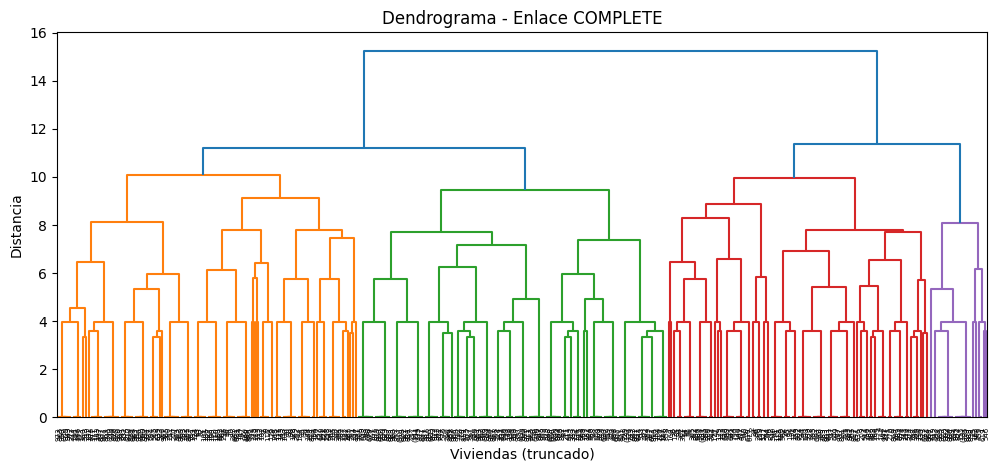

Tamaños de cluster (COMPLETE):
1    276
2    492
3    155
4     77
Name: count, dtype: int64


In [17]:
Z_complete = linkage( D, method="complete", optimal_ordering=True)

plt.figure(figsize=(12, 5))
dendrogram(Z_complete, truncate_mode="level", p=12, leaf_rotation=90)
plt.title("Dendrograma - Enlace COMPLETE")
plt.xlabel("Viviendas (truncado)")
plt.ylabel("Distancia")
plt.show()

K = 4
labels_complete = fcluster(Z_complete, t=K, criterion="maxclust")

print("Tamaños de cluster (COMPLETE):")
print(pd.Series(labels_complete).value_counts().sort_index())


#### <font color='022257'> Visualizacion del dendograma con enlace single </font>

/tmp/ipython-input-952219615.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_single = linkage(D, method="single", optimal_ordering=True) # culstering jerarquico


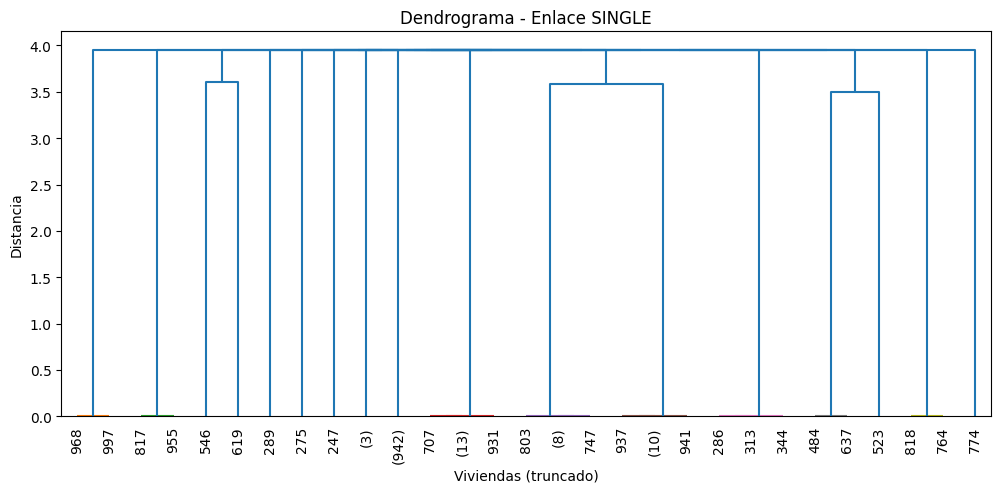

Tamaños de cluster (SINGLE):
1    1000
Name: count, dtype: int64


In [19]:
Z_single = linkage(D, method="single", optimal_ordering=True) # culstering jerarquico

plt.figure(figsize=(12, 5))
dendrogram(Z_single, truncate_mode="level", p=12, leaf_rotation=90)
plt.title("Dendrograma - Enlace SINGLE")
plt.xlabel("Viviendas (truncado)")
plt.ylabel("Distancia")
plt.show()

K = 4
labels_single = fcluster(Z_single, t=K, criterion="maxclust")

print("Tamaños de cluster (SINGLE):")
print(pd.Series(labels_single).value_counts().sort_index())

if len(np.unique(labels_single)) > 1 and len(np.unique(labels_single)) < n:
    sil = silhouette_score(D_square, labels_single, metric="precomputed")
    print(f"Silhouette (SINGLE, K={K}): {sil:.4f}")


#### <font color='022257'> Visualización del dendograma con enlace average </font>

/tmp/ipython-input-3801308780.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_average = linkage(D, method="average", optimal_ordering=True)


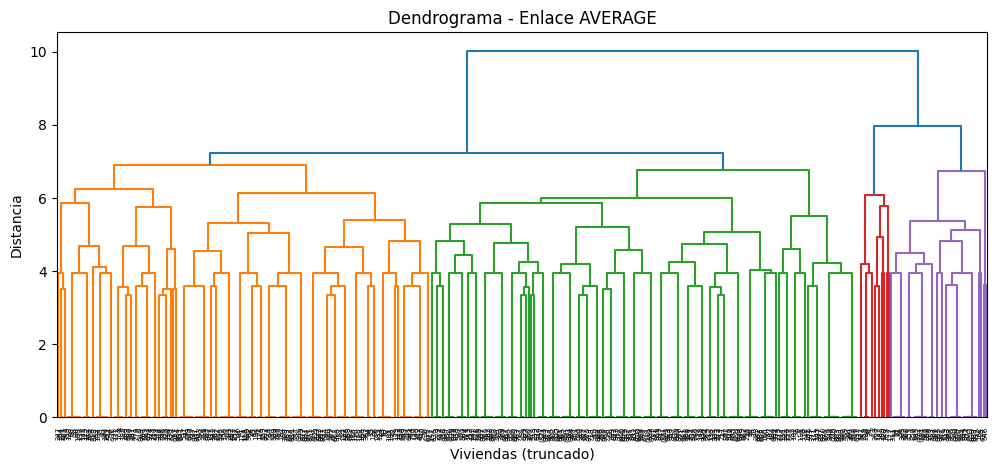

Tamaños de cluster (AVERAGE):
1    256
2    625
3     14
4    105
Name: count, dtype: int64


In [20]:
Z_average = linkage(D, method="average", optimal_ordering=True)

plt.figure(figsize=(12, 5))
dendrogram(Z_average, truncate_mode="level", p=12, leaf_rotation=90)
plt.title("Dendrograma - Enlace AVERAGE")
plt.xlabel("Viviendas (truncado)")
plt.ylabel("Distancia")
plt.show()

K = 4
labels_average = fcluster(Z_average, t=K, criterion="maxclust")

print("Tamaños de cluster (AVERAGE):")
print(pd.Series(labels_average).value_counts().sort_index())



#### <font color='022257'> Clustering jerárquico y definición del punto de corte
 </font>
Se construye el agrupamiento jerárquico con enlace complete usando la matriz de distancias.
Se busca una altura de corte que produzca cerca de 4 grupos.
Luego se asigna un cluster a cada vivienda y se revisan los tamaños.
Finalmente se grafica el dendrograma con la línea de corte para visualizar los grupos.



/tmp/ipython-input-4072807407.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_complete = linkage(D, method="complete", optimal_ordering=True)


Altura de corte (distancia) ≈ 10.650631
Clusters obtenidos con ese corte: 4
Tamaños de cluster (COMPLETE):
1    276
2    492
3    155
4     77
Name: count, dtype: int64


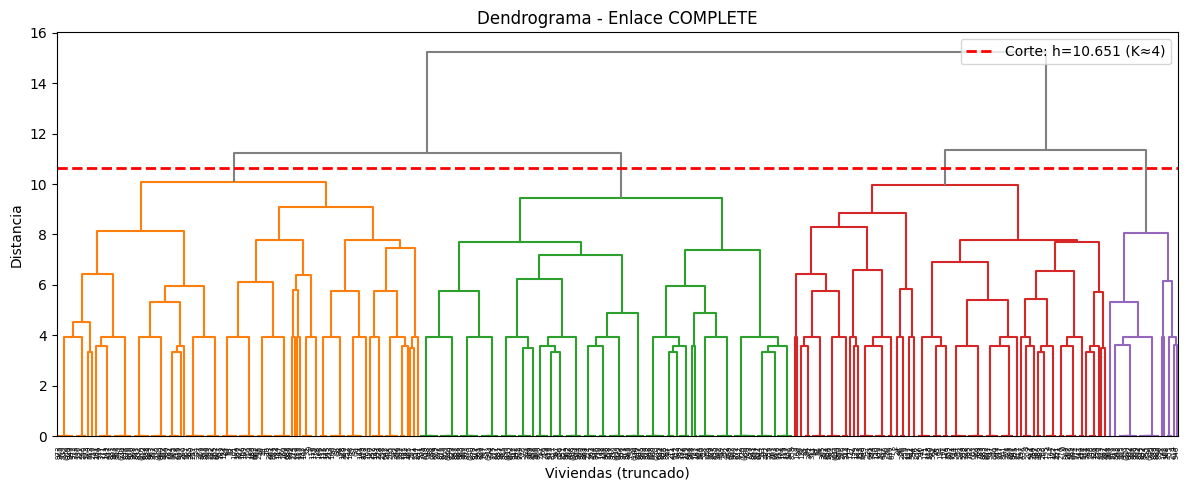

In [21]:
Z_complete = linkage(D, method="complete", optimal_ordering=True)

def cut_height_for_k(Z, K):
    dists = np.unique(Z[:, 2])
    dists = np.sort(dists)

    mids = (dists[:-1] + dists[1:]) / 2
    eps = 1e-12
    candidates = np.concatenate(([max(0.0, dists[0] - eps)], mids, [dists[-1] + eps]))

    counts = []
    for t in candidates:
        labs = fcluster(Z, t=t, criterion="distance")
        counts.append(len(np.unique(labs)))

    counts = np.array(counts)

    # Intentar exacto K
    idx = np.where(counts == K)[0]
    if len(idx) > 0:
        t = candidates[idx[0]]  # la menor altura que ya produce K
        return t, K

    j = int(np.argmin(np.abs(counts - K)))
    return candidates[j], int(counts[j])

K = 4
cut_h, k_obtenido = cut_height_for_k(Z_complete, K)

labels_complete = fcluster(Z_complete, t=cut_h, criterion="distance")

print(f"Altura de corte (distancia) ≈ {cut_h:.6f}")
print(f"Clusters obtenidos con ese corte: {k_obtenido}")

print("Tamaños de cluster (COMPLETE):")
print(pd.Series(labels_complete).value_counts().sort_index())

plt.figure(figsize=(12, 5))
dendrogram(
    Z_complete,
    truncate_mode="level",
    p=12,
    leaf_rotation=90,
    color_threshold=cut_h,
    above_threshold_color="grey"
)

plt.axhline(
    y=cut_h,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Corte: h={cut_h:.3f} (K≈{k_obtenido})"
)

plt.title("Dendrograma - Enlace COMPLETE")
plt.xlabel("Viviendas (truncado)")
plt.ylabel("Distancia")
plt.legend()
plt.tight_layout()
plt.show()

#### <font color='022257'> Perfil y caracterización de clusters </font>

Se asegura que la distancia esté en el formato correcto para el clustering (vector condensado).
Se calcula el clustering jerárquico y se asigna un número de cluster a cada vivienda.
Se limpian las variables usadas: convertir a 0/1 y reemplazar faltantes por 0, igual que en el clustering.
Luego se resume cada cluster con proporción y conteo de 1 y 0, y se muestran ejemplos de viviendas por cluster.


In [22]:
feature_cols = [
    "a1_tiene_luz_electrica",
    "a8_hierve_o_usa_cloro_en_el_agua_antes_de_beberla",
    "c2_productos_agricolas_como_maiz_etc",
    "d1_ha_fumigado_ud_mismo_su_casa",
    "d2_ha_fumigado_snem_su_casa",
    "e2_tiene_un_gallinero",
    "e3_perros",
    "e10_gatos",
]
id_col = "codigo_vivienda"

# Asegurar que D esté en formato
D_arr = np.asarray(D)
if D_arr.ndim == 2:
    D_condensed = squareform(D_arr, checks=False)
else:
    D_condensed = D_arr

# LINKAGE + fcluster
method = "complete"
K = 4

Z = linkage(D_condensed, method=method, optimal_ordering=True)
labels = fcluster(Z, t=K, criterion="maxclust")

# etiquetar viviendas  df
df_clusters = df.copy()
df_clusters[f"cluster_{method}"] = labels

print("Tamaños de cluster:")
print(df_clusters[f"cluster_{method}"].value_counts().sort_index())


# PERFIL DE CLUSTERS (proporción por variable)
X = df_clusters[feature_cols].copy()

# convertir a 0/1(bool, strings, num)
for c in X.columns:
    if X[c].dtype == bool:
        X[c] = X[c].astype("int8")
    else:
        X[c] = pd.to_numeric(X[c], errors="coerce")

X = X.fillna(0).round(0).astype("int8")

grp = df_clusters[f"cluster_{method}"]

# tamaño por cluster
n = grp.value_counts().sort_index()

# proporción de 1s (promedio), conteo de 1s, y 0s
p1 = X.groupby(grp).mean().sort_index()
ones = X.groupby(grp).sum().sort_index()
zeros = pd.DataFrame(np.repeat(n.values[:, None], len(feature_cols), axis=1),
                     index=n.index, columns=feature_cols) - ones

# tabla resumen
summary = pd.concat(
    {"p(1)": p1, "ones": ones, "zeros": zeros},
    axis=1
)

print("\n=== Perfil por cluster (p(1), #1, #0) ===")
print(summary)


# variables más frecuentes en cada cluster
top_m = 6
for k in n.index:
    s = pd.DataFrame({
        "variable": feature_cols,
        "p(1)": p1.loc[k].values,
        "ones": ones.loc[k].values,
        "zeros": zeros.loc[k].values,
    }).sort_values("p(1)", ascending=False)

    print(f"\n--- Cluster {k} (n={n.loc[k]}) | Top variables con más '1' ---")
    print(s.head(top_m).to_string(index=False))

    print(f"\n--- Cluster {k} (n={n.loc[k]}) | Top variables con más '0' ---")
    print(s.tail(top_m).sort_values("p(1)", ascending=True).to_string(index=False))

# Visualizar

cols_to_show = ([id_col] if id_col in df_clusters.columns else []) + feature_cols + [f"cluster_{method}"]

for k in n.index:
    sub = df_clusters.loc[df_clusters[f"cluster_{method}"] == k, cols_to_show]
    print(f"\n### Ejemplo de filas del Cluster {k} (primeras 15) ###")
    print(sub.head(15).to_string(index=False))


Tamaños de cluster:
cluster_complete
1    333
2    262
3    135
4    270
Name: count, dtype: int64

=== Perfil por cluster (p(1), #1, #0) ===
                                   p(1)  \
                 a1_tiene_luz_electrica   
cluster_complete                          
1                              0.873874   
2                              0.996183   
3                              0.985185   
4                              0.966667   

                                                                    \
                 a8_hierve_o_usa_cloro_en_el_agua_antes_de_beberla   
cluster_complete                                                     
1                                                         0.606607   
2                                                         0.591603   
3                                                         0.162963   
4                                                         0.033333   

                                                       \
        

Se probó clustering jerarquico aglomerativo, pero al tener limitaciones en introducirle gran cantidad de varibles, solo se lo analizó como uso exploratorio.

---
## <font color='264CC7'> Clustering K means con distancia Euclídea </font> </font>

##### <font color='022257'> Ponderar de cada grupo por pregunta </font>

Lo que se hace es escalar las variables one-hot por pregunta, antes de aplicar K-Means con distancia euclídea.

En one-hot, una misma pregunta puede generar m columnas. Si no se corrige esto, las preguntas con más columnas tienden a dominar la distancia euclídea, porque aportan más dimensiones y por tanto más “peso” en el cálculo de similitud.

Para evitarlo, a cada columna del grupo (pregunta) se le aplica el factor:

$w=\frac{1}{\sqrt{m}}$


Para que el aporte total de esa pregunta al espacio de distancias queda más comparable entre preguntas con distinto número de opciones (2, 4, 5, + ), así mejorando la equidad de influencia entre preguntas, hace los clusters menos sesgados hacia preguntas con más categorías.

In [23]:
def ponderar_por_pregunta(df: pd.DataFrame,
                          onehot_groups: dict[str, list[str]],
                          yesno_cols: list[str],
                          fillna_value=0,
                          include_only_existing=True):

    # Armar lista de columnas
    onehot_cols = sorted({c for cols in onehot_groups.values() for c in cols})
    cols = onehot_cols + list(yesno_cols)

    if include_only_existing:
        cols = [c for c in cols if c in df.columns]

    X = df[cols].copy()

    # Pasar todo a numérico y rellenar NA
    for c in X.columns:
        if X[c].dtype == bool:
            X[c] = X[c].astype("float32")
        else:
            X[c] = pd.to_numeric(X[c], errors="coerce")

    if fillna_value is not None:
        X = X.fillna(fillna_value)

    # Calcular pesos por pregunta
    weights_by_col = pd.Series(1.0, index=X.columns, dtype="float64")
    weights_by_question_rows = []

    for q, cols_q in onehot_groups.items():
        if include_only_existing:
            cols_q = [c for c in cols_q if c in X.columns]
        if not cols_q:
            continue

        m = len(cols_q)
        w = 1.0 / np.sqrt(m)

        # aplicar a las columnas del grupo
        X.loc[:, cols_q] = X.loc[:, cols_q] * w
        weights_by_col.loc[cols_q] = w

        weights_by_question_rows.append({
            "pregunta": q,
            "m_columnas": m,
            "w = 1/sqrt(m)": w,
            "columnas": cols_q
        })

    weights_by_question = (pd.DataFrame(weights_by_question_rows)
                           .sort_values(["m_columnas", "pregunta"])
                           .reset_index(drop=True))

    return X, weights_by_col, weights_by_question

# onehot_groups, yesno_cols

X_kmeans, w_cols, w_questions = ponderar_por_pregunta(
    df,
    onehot_groups=onehot_groups,
    yesno_cols=yesno_cols,
    fillna_value=0
)

print("X_kmeans shape:", X_kmeans.shape)
print("\nPesos por pregunta:")
print(w_questions[["pregunta", "m_columnas", "w = 1/sqrt(m)"]])

# peso aplicado a cada columna
print(w_cols.sort_values())


X_kmeans shape: (1000, 48)

Pesos por pregunta:
  pregunta  m_columnas  w = 1/sqrt(m)
0       a5           3       0.577350
1       b2           3       0.577350
2       a6           4       0.500000
3       f1           4       0.500000
4       f2           4       0.500000
5       f3           4       0.500000
6       a7           5       0.447214
7       b1           6       0.408248
8       b3           6       0.408248
b1_asbestos_o_similares                                     0.408248
b1_losa_de_hormigon                                         0.408248
b1_otros_materiales                                         0.408248
b1_paja_palma_o_similares                                   0.408248
b3_baldosa_o_vinyl                                          0.408248
b3_entablado_rustico                                        0.408248
b1_zinc                                                     0.408248
b1_teja                                                     0.408248
b3_otros_materiales 

/tmp/ipython-input-2111595160.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<FloatingArray>
[0.5773502691896258,                0.0, 0.5773502691896258,
                0.0, 0.5773502691896258, 0.5773502691896258,
 0.5773502691896258, 0.5773502691896258,                0.0,
                0.0,
 ...
 0.5773502691896258,                0.0,                0.0,
                0.0,                0.0,                0.0,
                0.0,                0.0,                0.0,
                0.0]
Length: 1000, dtype: Float64' has dtype incompatible with Int64, please explicitly cast to a compatible dtype first.
  X.loc[:, cols_q] = X.loc[:, cols_q] * w
/tmp/ipython-input-2111595160.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<FloatingArray>
[               0.0, 0.5773502691896258,                0.0,
                0.0,     

##### <font color='022257'> Preparación, estandarización y ponderación de variables one-hot- Construción de la matriz ponderada </font>

Se juntan todas las columnas one-hot y se convierten a números, dejando errores como vacío.
Los valores faltantes se reemplazan por 0.
Se separan columnas binarias (0/1) de las numéricas y se estandarizan las numéricas para que queden en la misma escala.
Luego se aplican pesos a cada grupo one-hot para que preguntas con muchas opciones no dominen el análisis.


In [24]:
# Varible en one hot
onehot_groups = {
    "a5": ["a5_escusado_de_uso_exclusivo_del_hogar", "a5_escusado_de_uso_comun_de_varios_hogares", "a5_no_tiene"],
    "a6": ["a6_red_publica_de_alcantarillado", "a6_pozo_ciego", "a6_pozo_septico", "a6_medio_ambiente"],
    "a7": ["a7_red_publica", "a7_pozo", "a7_carro_repartidor", "a7_otro", "a7_agua_de_lluvia"],
    "b1": ["b1_losa_de_hormigon", "b1_asbestos_o_similares", "b1_zinc", "b1_teja", "b1_paja_palma_o_similares", "b1_otros_materiales"],
    "b2": ["b2_hormigon_ladrillo_o_bloque", "b2_adobe_o_tapia", "b2_madera"],
    "b3": ["b3_entablado_rustico", "b3_parquet", "b3_baldosa_o_vinyl", "b3_ladrillo_o_cemento", "b3_tierra", "b3_otros_materiales"],
    "c2": ["c2_productos_agricolas_como_maiz_etc"],
    "d2": ["d2_ha_fumigado_snem_su_casa"],
    "e2": ["e2_tiene_un_gallinero",],
    "e3": ["e3_perros"],
    "e10": ["e10_gatos"],
    "f3": ["f3_raposas_zorros_guanchacas_o_zarigueyas_frecuentemente","f3_raposas_zorros_guanchacas_o_zarigueyas_nunca","f3_raposas_zorros_guanchacas_o_zarigueyas_rara_vez","f3_raposas_zorros_guanchacas_o_zarigueyas_siempre"]

}

all_cols = [c for cols in onehot_groups.values() for c in cols]

X = df[all_cols].copy()
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors="coerce")
X = X.fillna(0)

# Detectar columnas numéricas
def is_binary_series(s: pd.Series) -> bool:
    vals = set(pd.unique(s.dropna()))
    return vals.issubset({0, 1, 0.0, 1.0})

binary_cols = [c for c in X.columns if is_binary_series(X[c])]
numeric_cols = [c for c in X.columns if c not in binary_cols]

# Estandarizar numéricas (cuantos/meses/donde)
if numeric_cols:
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols].astype(float))

# w = 1/sqrt(m)
X_weighted = X.copy()
weights_per_group = {}

for g, cols in onehot_groups.items():
    m = len(cols)
    w = 1 / np.sqrt(m)
    weights_per_group[g] = w
    X_weighted[cols] = X_weighted[cols] * w

# Visualizacion de los pesos que tiene cada varible
print(pd.DataFrame({
    "pregunta": list(weights_per_group.keys()),
    "m_columnas": [len(onehot_groups[g]) for g in weights_per_group.keys()],
    "w": list(weights_per_group.values())
}).sort_values("pregunta"))


   pregunta  m_columnas         w
0        a5           3  0.577350
1        a6           4  0.500000
2        a7           5  0.447214
3        b1           6  0.408248
4        b2           3  0.577350
5        b3           6  0.408248
6        c2           1  1.000000
7        d2           1  1.000000
10      e10           1  1.000000
8        e2           1  1.000000
9        e3           1  1.000000
11       f3           4  0.500000


### <font color='022257'> Técnicas para hallar el mejor k </font>

##### <font color='022257'> Método del codo </font>

Se prueba KMeans con distintos números de clusters (2 a 8).
Se calcula la inercia de cada k (qué tan compactos quedan los grupos).
Se identifica automáticamente el “codo” donde la mejora deja de ser grande.
Se grafica inercia vs k y se marca el k recomendado.


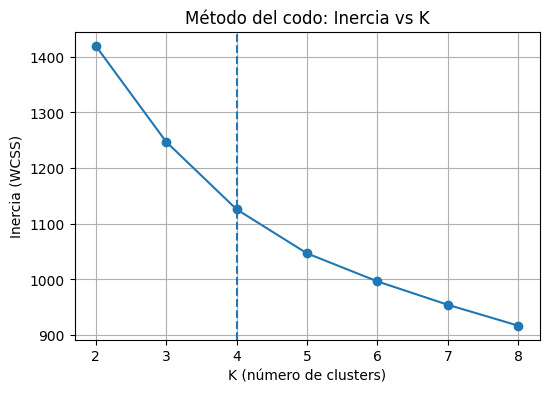

In [25]:
Ks = np.arange(2, 9)
inertias = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    km.fit(X_weighted)
    inertias.append(km.inertia_)

inertias = np.array(inertias, dtype=float)

#Codo
x = (Ks - Ks.min()) / (Ks.max() - Ks.min())
y = (inertias - inertias.min()) / (inertias.max() - inertias.min())

# Recta entre primer y último punto
p1 = np.array([x[0], y[0]])
p2 = np.array([x[-1], y[-1]])

# Distancia perpendicular
v = p2 - p1
dist = np.abs(v[0]*(p1[1]-y) - v[1]*(p1[0]-x)) / np.sqrt(v[0]**2 + v[1]**2)

idx_elbow = int(np.argmax(dist))
k_elbow = int(Ks[idx_elbow])

# Visualización de figura
plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker="o")
plt.axvline(k_elbow, linestyle="--")
plt.xlabel("K (número de clusters)")
plt.ylabel("Inercia (WCSS)")
plt.title("Método del codo: Inercia vs K")
plt.xticks(Ks)
plt.grid(True)
plt.show()



K candidatos por método del codo entre 4 a 6 que es donde ya no empieza haber cambios significativos.

##### <font color='022257'> Método del coeficiente Silhouette </font>

Se prueban varios valores de k (2 a 8) en KMeans.
Para cada k se calcula el índice silhouette, que mide qué tan bien separados quedan los grupos.
Se elige el k con el silhouette más alto y se grafica la curva, marcando el mejor k.


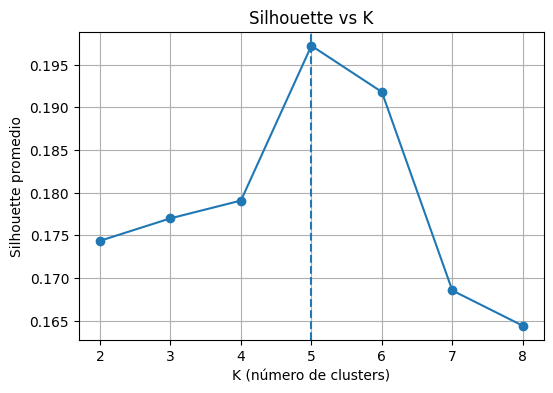

In [26]:
Ks = range(2, 9)
silhs = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    labels = km.fit_predict(X_weighted)
    silhs.append(silhouette_score(X_weighted, labels))

k_best = list(Ks)[int(np.argmax(silhs))]

plt.figure(figsize=(6,4))
plt.plot(list(Ks), silhs, marker="o")
plt.axvline(k_best, linestyle="--")
plt.xlabel("K (número de clusters)")
plt.ylabel("Silhouette promedio")
plt.title("Silhouette vs K")
plt.xticks(list(Ks))
plt.grid(True)
plt.show()

El mejor K según silhouette es 5 en donde llega a su punto máximo.

##### <font color='022257'> Explicación de la elección de trabajar con k = 4 </font>

Elegimos K=4 porque la inercia disminuye claramente hasta ese punto y luego la mejora es mínima.
Así, K=4 ofrece un buen balance entre calidad del agrupamiento y facilidad de interpretación.


In [27]:
K = 4
kmeans = KMeans(n_clusters=K, n_init=50, random_state=42)

labels = kmeans.fit_predict(X_weighted)

df["cluster_kmeans_5"] = labels + 1

print("Tamaños de cluster (K=5):")
print(df["cluster_kmeans_5"].value_counts().sort_index())

centroids = kmeans.cluster_centers_
print("Centroides shape:", centroids.shape)  # (5, n_features)

Tamaños de cluster (K=5):
cluster_kmeans_5
1    199
2    320
3    185
4    296
Name: count, dtype: int64
Centroides shape: (4, 36)


##### <font color='022257'> PCA (Análisis de Componentes Principales) para la visualización de mis clusters </font>

Para introducir el gráfico, se utiliza PCA (Análisis de Componentes Principales) como un método de reducción de dimensionalidad que proyecta las viviendas desde un espacio de muchas variables hacia un plano 2D, preservando la mayor variabilidad posible. Se proyectan también los centroides de K-Means en ese mismo plano.



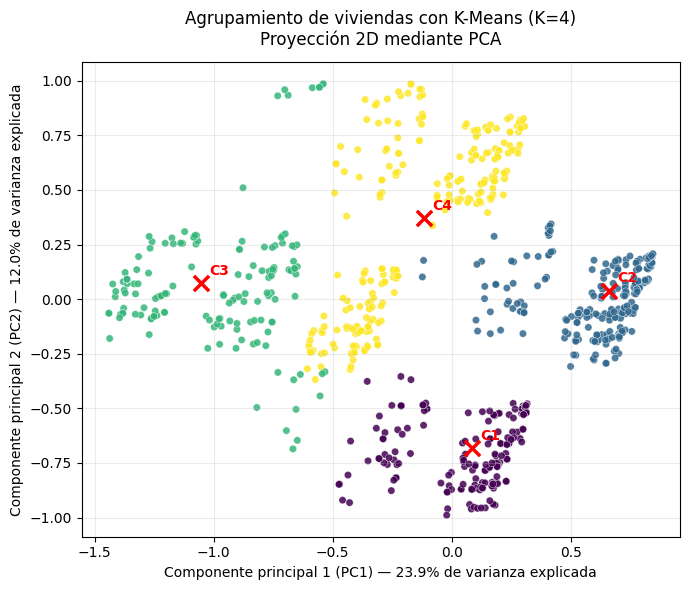

In [28]:
# PCA 2D

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_weighted.values)

# Proyectar centroides
centroids_2d = pca.transform(kmeans.cluster_centers_)

# % varianza explicada
var = pca.explained_variance_ratio_ * 100

K = len(np.unique(labels))


# Scatter

plt.figure(figsize=(7, 6))

# puntos (viviendas)
sc = plt.scatter(
    Z[:, 0], Z[:, 1],
    c=labels, s=28, alpha=0.85,
    edgecolors="white", linewidths=0.3
)

# centroides
plt.scatter(
    centroids_2d[:, 0], centroids_2d[:, 1],
    marker="x",
    s=120,
    linewidths=2.5,
    color="red",
    zorder=5
)

# etiqueta centroides
for i, (x, y) in enumerate(centroids_2d):
    plt.annotate(
        f"C{i+1}",
        (x, y),
        textcoords="offset points",
        xytext=(6, 6),
        fontsize=10,
        fontweight="bold",
        color="red"
    )

# títulos y ejes
plt.title("Agrupamiento de viviendas con K-Means (K=4)\nProyección 2D mediante PCA", pad=12)
plt.xlabel(f"Componente principal 1 (PC1) — {var[0]:.1f}% de varianza explicada")
plt.ylabel(f"Componente principal 2 (PC2) — {var[1]:.1f}% de varianza explicada")

plt.grid(True, alpha=0.25)
plt.box(True)

plt.tight_layout()
plt.show()


El gráfico muestra las viviendas agrupadas con K-Means K=4. Cada punto representa una vivienda y el color indica el cluster al que pertenece.
Los ejes corresponden a los dos componentes principales, que resumen la mayor variación de los datos.
Las cruces rojas señalan los centroides de los clusters, es decir, el perfil promedio de cada grupo en esta proyección.

##### <font color='022257'> Descripción de los clusters </font>

Se preparan los datos para interpretar los clusters.
Las variables se convierten a formato numérico y los valores faltantes se reemplazan por 0.
Se separan variables binarias y numéricas.
Luego se calcula, por cluster, cuántas viviendas hay y los promedios o proporciones de cada variable para describir cada grupo.


In [30]:
df = df.copy()
df["cluster"] = labels + 1

all_cols = [c for cols in onehot_groups.values() for c in cols]

X_raw = df[all_cols].copy()
for c in X_raw.columns:
    X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce")
X_raw = X_raw.fillna(0)

# detectar binarias vs numéricas
def is_binary_series(s: pd.Series) -> bool:
    vals = set(pd.unique(s.dropna()))
    return vals.issubset({0, 1, 0.0, 1.0})

binary_cols = [c for c in X_raw.columns if is_binary_series(X_raw[c])]
numeric_cols = [c for c in X_raw.columns if c not in binary_cols]


# Tabla resumen por cluster size binary numeric
summary_parts = []

# Tamaños
sizes = df.groupby("cluster").size().rename("n_viviendas").to_frame()

# proporciones binarias por cluster
bin_profile = df.groupby("cluster")[binary_cols].mean() if binary_cols else pd.DataFrame()

# Promedios numéricos por cluster
num_profile = df.groupby("cluster")[numeric_cols].mean() if numeric_cols else pd.DataFrame()

# redondeo para reporte
summary = sizes.copy()
if not num_profile.empty:
    summary = summary.join(num_profile.round(2))
if not bin_profile.empty:
    summary = summary.join(bin_profile.round(3))

print("\n=== TABLA RESUMEN POR CLUSTER (n, promedios y proporciones) ===")
display(summary)



=== TABLA RESUMEN POR CLUSTER (n, promedios y proporciones) ===


,n_viviendas,a5_escusado_de_uso_exclusivo_del_hogar,a5_escusado_de_uso_comun_de_varios_hogares,a5_no_tiene,a6_red_publica_de_alcantarillado,a6_pozo_ciego,a6_pozo_septico,a6_medio_ambiente,a7_red_publica,a7_pozo,...,b3_otros_materiales,c2_productos_agricolas_como_maiz_etc,d2_ha_fumigado_snem_su_casa,e2_tiene_un_gallinero,e3_perros,e10_gatos,f3_raposas_zorros_guanchacas_o_zarigueyas_frecuentemente,f3_raposas_zorros_guanchacas_o_zarigueyas_nunca,f3_raposas_zorros_guanchacas_o_zarigueyas_rara_vez,f3_raposas_zorros_guanchacas_o_zarigueyas_siempre
cluster,,,,,,,,,,,,,,,,,,,,,
1,199,0.342,0.025,0.412,0.06,0.146,0.211,0.563,0.663,0.07,...,0.005,0.0,0.207,0.829,0.935,1.0,0.0,0.549,0.0,0.0
2,320,0.275,0.012,0.459,0.059,0.112,0.147,0.678,0.647,0.094,...,0.009,1.0,0.128,0.922,0.925,1.0,0.0,0.553,0.0,0.0
3,185,0.27,0.057,0.379,0.057,0.057,0.178,0.529,0.563,0.063,...,0.0,0.056,0.167,0.236,0.184,0.067,0.0,0.524,0.0,0.0
4,296,0.358,0.007,0.419,0.061,0.098,0.22,0.608,0.74,0.074,...,0.014,0.615,0.166,0.919,0.926,0.0,0.0,0.644,0.0,0.0


Se calculan los promedios de cada variable por cluster.
Luego se comparan con el promedio global.
Así se identifican las variables que más destacan en cada cluster y lo definen mejor.


In [32]:
# promedios
profile = df.groupby("cluster")[all_cols].mean()

# promedio global
global_mean = df[all_cols].mean()

# diferencia vs global
delta = profile.sub(global_mean, axis=1)
TOP_N = 10

rows = []
for cl in sorted(df["cluster"].unique()):
    top = delta.loc[cl].sort_values(ascending=False).head(TOP_N)
    for var, d in top.items():
        rows.append({
            "cluster": cl,
            "variable": var,
            "prom_cluster": profile.loc[cl, var],
            "prom_global": global_mean[var],
            "delta_vs_global": d
        })

top_table = pd.DataFrame(rows)
top_table["prom_cluster"] = top_table["prom_cluster"].round(3)
top_table["prom_global"] = top_table["prom_global"].round(3)
top_table["delta_vs_global"] = top_table["delta_vs_global"].round(3)

print("\n Top variables que definen cada cluster vs promedio global")
display(top_table)


 Top variables que definen cada cluster vs promedio global


,cluster,variable,prom_cluster,prom_global,delta_vs_global
0,1,e10_gatos,1.000,0.542,0.458
1,1,e3_perros,0.935,0.804,0.131
2,1,b1_teja,0.920,0.810,0.110
3,1,b3_tierra,0.683,0.594,0.090
4,1,b2_adobe_o_tapia,0.709,0.660,0.048
5,1,d2_ha_fumigado_snem_su_casa,0.207,0.162,0.045
6,1,a6_pozo_ciego,0.146,0.105,0.041
7,1,e2_tiene_un_gallinero,0.829,0.789,0.040
8,1,a5_escusado_de_uso_exclusivo_del_hogar,0.342,0.312,0.029
9,1,a6_pozo_septico,0.211,0.187,0.024


In [33]:
ID_COL = None

print("\n=== EJEMPLOS DE VIVIENDAS POR CLUSTER ===")
for cl in sorted(df["cluster"].unique()):
    subset = df[df["cluster"] == cl]
    print(f"\nCluster {cl} | n={len(subset)}")
    if ID_COL and ID_COL in df.columns:
        print("IDs ejemplo:", subset[ID_COL].head(10).tolist())
    else:
        print("Índices ejemplo:", subset.index[:10].tolist())



=== EJEMPLOS DE VIVIENDAS POR CLUSTER ===

Cluster 1 | n=199
Índices ejemplo: [0, 9, 12, 14, 15, 19, 20, 21, 22, 28]

Cluster 2 | n=320
Índices ejemplo: [5, 6, 8, 18, 29, 58, 62, 63, 77, 78]

Cluster 3 | n=185
Índices ejemplo: [1, 2, 4, 7, 17, 23, 24, 25, 26, 30]

Cluster 4 | n=296
Índices ejemplo: [3, 10, 11, 13, 16, 27, 38, 40, 41, 43]


In [34]:
X_bool = X_jaccard.astype(bool)

# pdist devuelve forma condensada (n*(n-1)/2)
D_condensed = pdist(X_bool, metric="jaccard")

# convertir a matriz densa n x n
D = squareform(D_condensed)

print("D shape:", D.shape)


D shape: (1000, 1000)


---
## <font color='264CC7'> Conclusiones </font>

#### <font color='022257'> Cruce de clusters con status_entomologico  </font>

Cruzar los clusters perfiles de vivienda con status_entomologico, constituye una decisión metodológica clave porque permite pasar de un análisis descriptivo centrado en segmentar viviendas según su similitud, a un análisis epidemiológico y aplicado, orientado a identificar qué perfiles se asocian con una mayor probabilidad de presencia del vector de Chagas y, en consecuencia, con un mayor nivel de riesgo.

##### <font color='022257'> ¿Qué cluster tiene mayor proporción de viviendas con presencia del vector? </font>

In [36]:
status_col = "status_entomologico"

y_status = df[status_col].astype(str).str.strip().str.lower()

map_status = {
    "positiva": 1,
    "positiva ": 1,
    "positiva.": 1,
    "negativa": 0,
    "negativa ": 0,
    "negativa.": 0,
}

df["status_bin"] = y_status.map(map_status)

unknown = df.loc[df["status_bin"].isna(), status_col].value_counts()
display(unknown)


# tabla de conteos por cluster
counts = pd.crosstab(df["cluster"], df["status_bin"], dropna=False)

# Renombrar columnas a algo claro (0=Neg, 1=Pos)
counts = counts.rename(columns={0.0: "Negativa", 1.0: "Positiva", 0: "Negativa", 1: "Positiva"})

# Total por cluster y tasa de positivos
counts["Total_con_status"] = counts.sum(axis=1)
counts["Tasa_positivos"] = (counts.get("Positiva", 0) / counts["Total_con_status"]).round(4)

# Ordenar por mayor tasa de positivos
counts_sorted = counts.sort_values("Tasa_positivos", ascending=False)

print("\nConteos y tasa de positivos por cluster ordenado por riesgo")
display(counts_sorted)

# Prevalencia global
global_rate = df["status_bin"].mean(skipna=True)
print(f"\nPrevalencia global de positivos: {global_rate:.4f}")

,count
status_entomologico,



Conteos y tasa de positivos por cluster ordenado por riesgo


status_bin,Negativa,Positiva,Total_con_status,Tasa_positivos
cluster,,,,
2,274,46,320,0.1438
3,170,15,185,0.0811
4,272,24,296,0.0811
1,183,16,199,0.0804



Prevalencia global de positivos: 0.1010


**Clúster 1 — Vivienda rural tradicional con animales y materiales vulnerables**

Viviendas rurales con animales domésticos y materiales precarios que favorecen el refugio del vector.

Variables representativas:

e10_gatos

e3_perros

b1_teja

b3_tierra

b2_adobe_o_tapia

e2_tiene_un_gallinero

d2_ha_fumigado_snem_su_casa

**Clúster 2 — Rural agroproductiva con gallinero y corral**

Entornos rurales con fuerte actividad agroproductiva, gallineros y materiales tradicionales.

Variables representativas:

c2_productos_agricolas_como_maiz_etc

e2_tiene_un_gallinero

e10_gatos

e3_perros

b3_tierra

b2_adobe_o_tapia

b1_teja

**Clúster 3 — Vivienda consolidada con mejor infraestructura**

Viviendas de material sólido (ladrillo/hormigón), con menor riesgo estructural.

Variables representativas:

b2_hormigon_ladrillo_o_bloque

b1_zinc

b1_asbestos_o_similares

b1_losa_de_hormigon

b3_baldosa_o_vinyl

a5_escusado_de_uso_comun_de_varios_hogares

**Clúster 4 — Peridomicilio activo con gallinero, productos agrícolas y agua no red**

Entorno rural con gallineros, cultivos y fuentes de agua no convencionales, con riesgo ambiental alto.

Variables representativas:

e2_tiene_un_gallinero

c2_productos_agricolas_como_maiz_etc

a7_red_publica / a7_agua_de_lluvia

e3_perros

f3_raposas_zorros_guanchacas_o_zarigueyas_rara_vez

b3_ladrillo_o_cemento

b2_hormigon_ladrillo_o_bloque

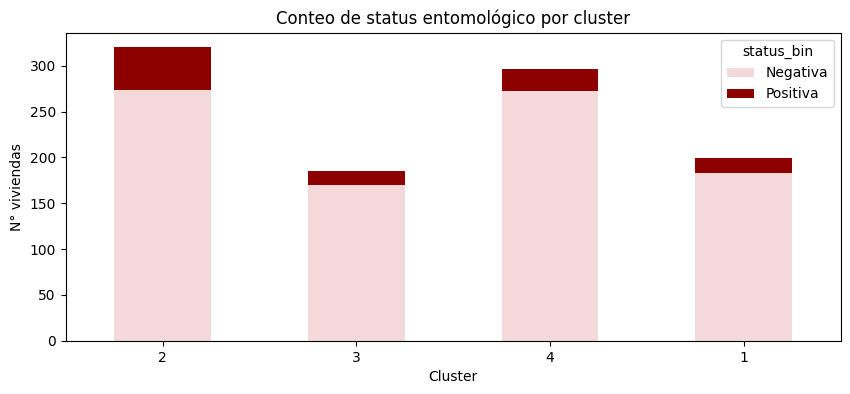

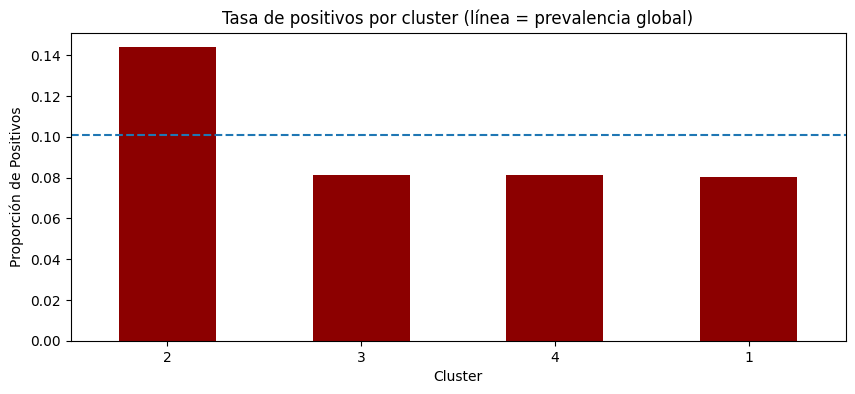

In [37]:


# 1) Conteos apilados
plot_counts = counts_sorted[["Negativa","Positiva"]].fillna(0)
colors = ["#F3D9D9","#8C0000"]
ax = plot_counts.plot(kind="bar", stacked=True, figsize=(10,4), color = colors)
ax.set_title("Conteo de status entomológico por cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("N° viviendas")
plt.xticks(rotation=0)
plt.show()

# 2) Tasa de positivos por cluster
ax = counts_sorted["Tasa_positivos"].plot(kind="bar", figsize=(10,4), color = colors[1] )
ax.axhline(global_rate, linestyle="--")  # línea de la prevalencia global
ax.set_title("Tasa de positivos por cluster (línea = prevalencia global)")
ax.set_xlabel("Cluster")
ax.set_ylabel("Proporción de Positivos")
plt.xticks(rotation=0)
plt.show()


In [38]:
# Cluster con mayor tasa de positivos el primero del ordenado
cluster_mas_riesgo = counts_sorted.index[0]
print("Cluster con mayor tasa de positivos:", cluster_mas_riesgo)

viviendas_positivas_cluster = df[(df["cluster"] == cluster_mas_riesgo) & (df["status_bin"] == 1)]
print("N° viviendas positivas en ese cluster:", len(viviendas_positivas_cluster))

# ID de vivienda
cols_show = [c for c in ["id_vivienda", status_col, "cluster"] if c in df.columns]
display(viviendas_positivas_cluster[cols_show].head(50))


Cluster con mayor tasa de positivos: 2
N° viviendas positivas en ese cluster: 46


,status_entomologico,cluster
92,Positiva,2
130,Positiva,2
200,Positiva,2
214,Positiva,2
224,Positiva,2
240,Positiva,2
241,Positiva,2
261,Positiva,2
272,Positiva,2
274,Positiva,2


#### <font color='022257'> Tabla de variables relevantes del cluster 2  </font>
El cluster que más casos positvos guarda, se le hace un filtro y se visualiza.

In [39]:
display(top_table[top_table["cluster"] == 2].reset_index(drop=True))

,cluster,variable,prom_cluster,prom_global,delta_vs_global
0,2,c2_productos_agricolas_como_maiz_etc,1.000,0.523,0.477
1,2,e10_gatos,1.000,0.542,0.458
2,2,e2_tiene_un_gallinero,0.922,0.789,0.133
3,2,e3_perros,0.925,0.804,0.121
4,2,b3_tierra,0.697,0.594,0.103
5,2,b2_adobe_o_tapia,0.753,0.660,0.093
6,2,b1_teja,0.897,0.810,0.087
7,2,a6_medio_ambiente,0.678,0.608,0.070
8,2,a5_no_tiene,0.459,0.424,0.036
9,2,b3_entablado_rustico,0.097,0.075,0.022


#### <font color='022257'> Tabla de variables menos representativas del cluster 2  </font>

Se identifican las variables con valores más bajos que el promedio global, para ver qué características están menos presentes en ese grupo.

In [40]:
cl = 2
TOP_N = 10

top_down = delta.loc[cl].sort_values(ascending=True).head(TOP_N)
display(pd.DataFrame({"delta_vs_global": top_down}).rename_axis("variable").reset_index())

,variable,delta_vs_global
0,b2_hormigon_ladrillo_o_bloque,-0.056275
1,a6_pozo_septico,-0.040183
2,b1_zinc,-0.039993
3,a5_escusado_de_uso_exclusivo_del_hogar,-0.037437
4,d2_ha_fumigado_snem_su_casa,-0.03376
5,f3_raposas_zorros_guanchacas_o_zarigueyas_nunca,-0.021741
6,b1_losa_de_hormigon,-0.017559
7,b3_ladrillo_o_cemento,-0.017135
8,a7_red_publica,-0.016421
9,b3_baldosa_o_vinyl,-0.0091


#### <font color='022257'>  Carcaterísticas y variables de perfiles de viviendas que presentan condiciones que favorecen la presencia del vector del Chagas   </font>

Al analizar mis resultados ,obtenemos las siguientes observaciones.-

Perfil del cluster de condiciones **más favorables** para el vector

* entorno agro-rural o agrícola: c2_productos_agricolas_como_maiz_etc
* presencia de animales en el peridomicilio: e10_gatos, e3_perros, e2_tiene_un_gallinero
* mayor vulnerabilidad estructural: b2_adobe_o_tapia, b3_tierra
* construcción más rústica o menos “sellada”: b1_teja, b3_entablado_rustico
* saneamiento más precario y señales de menor acceso a servicios: a6_medio_ambiente, a5_no_tiene

Características **menos presentes** en el cluster 2

* materiales más resistentes o sellados: b2_hormigon_ladrillo_o_bloque, b3_ladrillo_o_cemento, b1_losa_de_hormigon, b3_baldosa_o_vinyl
* mejor saneamiento: a6_pozo_septico, a5_escusado_de_uso_exclusivo_del_hogar
* mayor acceso a red pública de agua: a7_red_publica
* menor presencia de techo de zinc: b1_zinc, lo que sugiere un perfil más ligado a vivienda tradicional/rural

**Conclusión**
El cluster 2 combina viviendas más vulnerables (adobe/tapia y piso de tierra), mayor presencia de animales y gallinero, y menor saneamiento o servicios. Se concluye que esta mezcla favorece la presencia del vector porque aporta refugios, alimento y un entorno peridomiciliario más propicio para la colonización.


---
## <font color='264CC7'> Clusterig DBSCAN con Jaccard </font>

#### <font color='022257'> Frecuencia y prevalencia de variables binarias  </font>

Se cuenta cuántas viviendas tienen valor 1 en cada variable.
Luego se calcula la prevalencia, es decir, el porcentaje de viviendas donde aparece cada característica.
Finalmente se ordenan las variables para ver cuáles son más comunes y cuáles son más raras.


In [41]:
# Conteo de 1s por variable
freq_ones = X_jaccard.sum(axis=0).sort_values(ascending=False)

# Prevalencia
prev_pct = (freq_ones / len(X_jaccard) * 100).round(2)

# Tabla por prevalencia
freq_table = (
    pd.DataFrame({
        "variable": freq_ones.index,
        "n_1": freq_ones.values,
        "prevalencia_pct": prev_pct.values
    })
    .reset_index(drop=True)
)

display(freq_table)

# visualiza 30 más frecuentes
display(freq_table.head(30))

# vizualiza las 30 menos frecuentes (muy raras)
display(freq_table.tail(30))


,variable,n_1,prevalencia_pct
0,a1_tiene_luz_electrica,946,94.6
1,e1_gallinas_o_palomas_u_otras_aves,864,86.4
2,b1_teja,801,80.1
3,e3_perros,786,78.6
4,e2_tiene_un_gallinero,770,77.0
5,f1_ratones_sin_respuesta,744,74.4
6,f2_ratas_sin_respuesta,739,73.9
7,a7_red_publica,656,65.6
8,b2_adobe_o_tapia,653,65.3
9,a6_medio_ambiente,601,60.1


,variable,n_1,prevalencia_pct
0,a1_tiene_luz_electrica,946,94.6
1,e1_gallinas_o_palomas_u_otras_aves,864,86.4
2,b1_teja,801,80.1
3,e3_perros,786,78.6
4,e2_tiene_un_gallinero,770,77.0
5,f1_ratones_sin_respuesta,744,74.4
6,f2_ratas_sin_respuesta,739,73.9
7,a7_red_publica,656,65.6
8,b2_adobe_o_tapia,653,65.3
9,a6_medio_ambiente,601,60.1


,variable,n_1,prevalencia_pct
20,b2_hormigon_ladrillo_o_bloque,272,27.2
21,f2_ratas_nunca,261,26.1
22,f1_ratones_nunca,256,25.6
23,a7_rio_vertiente_acequia_o_canal,229,22.9
24,a5_letrina,209,20.9
25,a6_pozo_septico,185,18.5
26,d2_ha_fumigado_snem_su_casa,158,15.8
27,c1_lena,138,13.8
28,b1_zinc,123,12.3
29,a6_pozo_ciego,104,10.4


#### <font color='022257'> Distribución de la variable epidemiológica </font>

In [42]:
# Conteo absoluto
status_counts = y_status.value_counts(dropna=False)

# Proporción (%)
status_pct = (status_counts / status_counts.sum() * 100).round(2)

status_distribution = pd.DataFrame({
    "conteo": status_counts,
    "porcentaje_%": status_pct
})

display(status_distribution)


,conteo,porcentaje_%
status_entomologico,,
negativa,899,89.9
positiva,101,10.1


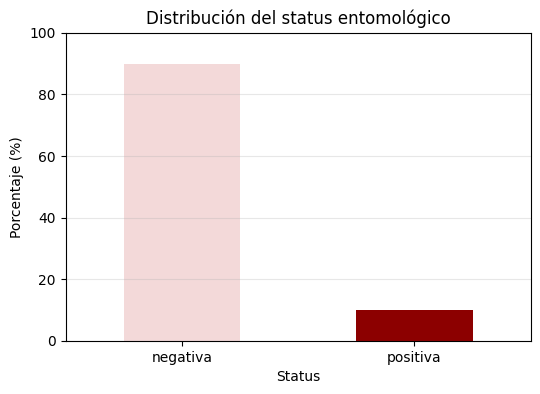

In [43]:
status_distribution["porcentaje_%"].plot(
    kind="bar",
    figsize=(6,4),
    color = colors,
    rot=0
)

plt.title("Distribución del status entomológico")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Status")
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.3)
plt.show()


#### <font color='022257'> Matriz de distancias Jaccard (n x n)</font>

In [45]:
X_bool = X_jaccard.astype(bool)

# pdist devuelve forma condensada (n*(n-1)/2)
D_condensed = pdist(X_bool, metric="jaccard")

# convertir a matriz densa n x n
D = squareform(D_condensed)

print("D shape:", D.shape)


D shape: (1000, 1000)


#### <font color='022257'> Elección de parámetros de DBSCAN y aplicación</font>

Se usa DBSCAN para agrupar viviendas similares y detectar ruido.
eps = 0.24 permite agrupar viviendas con similitud moderada sin mezclar perfiles distintos.
min_samples = 15 asegura que cada cluster tenga suficiente tamaño y sea estable.

In [46]:
eps = 0.24
min_samples = 15

db = DBSCAN(
    eps=eps,
    min_samples=min_samples,
    metric="precomputed",
    n_jobs=-1
)

labels = db.fit_predict(D)

# -1 = ruido
print("Clusters:", len(set(labels)) - (1 if -1 in labels else 0))
print("Ruido:", np.sum(labels == -1), "de", len(labels))

df_result = df_clean.copy()
df_result["cluster_dbscan"] = labels
df_result["is_noise"] = (labels == -1).astype(int)

# Tamaños por cluster
print(df_result["cluster_dbscan"].value_counts().sort_index())


Clusters: 2
Ruido: 335 de 1000
cluster_dbscan
-1    335
 0    628
 1     37
Name: count, dtype: int64


In [47]:
profile_by_group = (
    X_jaccard[kept_cols]
    .groupby(df_result["cluster_dbscan"])
    .mean()
    .round(3)
)

display(profile_by_group)


,a1_tiene_luz_electrica,a5_escusado_de_uso_exclusivo_del_hogar,a5_escusado_de_uso_comun_de_varios_hogares,a5_letrina,a5_no_tiene,a6_red_publica_de_alcantarillado,a6_pozo_ciego,a6_pozo_septico,a6_medio_ambiente,a7_red_publica,...,e2_tiene_un_gallinero,e3_perros,e4_duerme_el_perro_dentro_de_la_casa,e10_gatos,f1_ratones_sin_respuesta,f1_ratones_nunca,f2_ratas_sin_respuesta,f2_ratas_nunca,f3_raposas_zorros_guanchacas_o_zarigueyas_sin_respuesta,f3_raposas_zorros_guanchacas_o_zarigueyas_nunca
cluster_dbscan,,,,,,,,,,,,,,,,,,,,,
-1,0.967,0.442,0.057,0.206,0.284,0.143,0.131,0.245,0.445,0.707,...,0.636,0.672,0.057,0.409,0.627,0.373,0.600,0.400,0.424,0.576
0,0.990,0.256,0.003,0.223,0.516,0.018,0.096,0.164,0.720,0.667,...,0.887,0.893,0.041,0.626,0.791,0.209,0.798,0.202,0.533,0.467
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000


#### <font color='022257'> Perfil y comparación de clusters respecto al promedio global </font>

Se analizan los clusters obtenidos con DBSCAN.
Se calcula cuántas viviendas hay en cada grupo.
Luego se compara cada cluster con el promedio global para identificar las variables que más aumentan y las que más disminuyen.
Esto sirve para describir y caracterizar el perfil de cada cluster, incluido el ruido.


In [49]:
def perfil_binario_por_grupo(df_result: pd.DataFrame,
                             X_bin: pd.DataFrame,
                             group_col: str = "cluster_dbscan",
                             top_n: int = 20):

    # asegurar alineación por índice
    assert len(df_result) == len(X_bin), "df_result y X_bin deben tener el mismo número de filas"
    assert (df_result.index == X_bin.index).all(), "df_result y X_bin deben tener el mismo índice/orden"

    # proporción global (prevalencia global)
    p_global = X_bin.mean(axis=0)

    # tamaños
    size_table = df_result[group_col].value_counts(dropna=False).sort_index()
    size_table = size_table.rename("n_viviendas").to_frame()
    size_table["pct"] = (size_table["n_viviendas"] / len(df_result) * 100).round(2)

    tops_up = {}
    tops_down = {}

    for g in sorted(df_result[group_col].unique()):
        mask = (df_result[group_col] == g)
        Xg = X_bin.loc[mask]

        # proporción dentro del grupo
        p_g = Xg.mean(axis=0)

        # delta vs global
        delta = (p_g - p_global).sort_values(ascending=False)

        # armar tabla top
        top_up = pd.DataFrame({
            "variable": delta.head(top_n).index,
            "p_grupo": p_g.loc[delta.head(top_n).index].values,
            "p_global": p_global.loc[delta.head(top_n).index].values,
            "delta": delta.head(top_n).values
        })
        top_down = pd.DataFrame({
            "variable": delta.tail(top_n).index,
            "p_grupo": p_g.loc[delta.tail(top_n).index].values,
            "p_global": p_global.loc[delta.tail(top_n).index].values,
            "delta": delta.tail(top_n).values
        }).sort_values("delta")  # más negativo arriba

        # redondeos
        for t in (top_up, top_down):
            t["p_grupo"] = t["p_grupo"].round(3)
            t["p_global"] = t["p_global"].round(3)
            t["delta"] = t["delta"].round(3)

        tops_up[g] = top_up.reset_index(drop=True)
        tops_down[g] = top_down.reset_index(drop=True)

    return size_table, tops_up, tops_down


# Ejecutar perfil con X_jaccard
size_table, tops_up, tops_down = perfil_binario_por_grupo(
    df_result=df_result,
    X_bin=X_jaccard[kept_cols],   # asegúrate que sea 0/1
    group_col="cluster_dbscan",
    top_n=20
)

print("Tamaños por grupo y ruido")
display(size_table)

# Mostrar top variables para cada grupo
for g in sorted(df_result["cluster_dbscan"].unique()):
    nombre = "Ruido (-1)" if g == -1 else f"Cluster {g}"
    print(f"\n===== {nombre}: Variables que más suben vs global =====")
    display(tops_up[g])

    print(f"\n===== {nombre}: Variables que más bajan vs global =====")
    display(tops_down[g])


Tamaños por grupo y ruido


,n_viviendas,pct
cluster_dbscan,,
-1,335,33.5
0,628,62.8
1,37,3.7



===== Ruido (-1): Variables que más suben vs global =====


,variable,p_grupo,p_global,delta
0,b2_hormigon_ladrillo_o_bloque,0.558,0.272,0.286
1,b3_ladrillo_o_cemento,0.588,0.428,0.160
2,f2_ratas_nunca,0.400,0.261,0.139
3,a5_escusado_de_uso_exclusivo_del_hogar,0.442,0.309,0.133
4,f1_ratones_nunca,0.373,0.256,0.117
5,b1_zinc,0.227,0.123,0.104
6,f3_raposas_zorros_guanchacas_o_zarigueyas_nunca,0.576,0.486,0.090
7,d2_ha_fumigado_snem_su_casa,0.248,0.158,0.090
8,a6_red_publica_de_alcantarillado,0.143,0.059,0.084
9,a8_hierve_o_usa_cloro_en_el_agua_antes_de_beberla,0.463,0.388,0.075



===== Ruido (-1): Variables que más bajan vs global =====


,variable,p_grupo,p_global,delta
0,b2_adobe_o_tapia,0.370,0.653,-0.283
1,b3_tierra,0.394,0.587,-0.193
2,b1_teja,0.615,0.801,-0.186
3,a6_medio_ambiente,0.445,0.601,-0.156
4,f2_ratas_sin_respuesta,0.600,0.739,-0.139
5,a5_no_tiene,0.284,0.419,-0.135
6,e2_tiene_un_gallinero,0.636,0.770,-0.134
7,c2_productos_agricolas_como_maiz_etc,0.379,0.511,-0.132
8,e10_gatos,0.409,0.530,-0.121
9,f1_ratones_sin_respuesta,0.627,0.744,-0.117



===== Cluster 0: Variables que más suben vs global =====


,variable,p_grupo,p_global,delta
0,b2_adobe_o_tapia,0.842,0.653,0.189
1,b1_teja,0.947,0.801,0.146
2,b3_tierra,0.725,0.587,0.138
3,a6_medio_ambiente,0.720,0.601,0.119
4,e2_tiene_un_gallinero,0.887,0.770,0.117
5,e3_perros,0.893,0.786,0.107
6,c2_productos_agricolas_como_maiz_etc,0.611,0.511,0.100
7,e1_gallinas_o_palomas_u_otras_aves,0.963,0.864,0.099
8,a5_no_tiene,0.516,0.419,0.097
9,e10_gatos,0.626,0.530,0.096



===== Cluster 0: Variables que más bajan vs global =====


,variable,p_grupo,p_global,delta
0,b2_hormigon_ladrillo_o_bloque,0.135,0.272,-0.137
1,b3_ladrillo_o_cemento,0.368,0.428,-0.060
2,f2_ratas_nunca,0.202,0.261,-0.059
3,a5_escusado_de_uso_exclusivo_del_hogar,0.256,0.309,-0.053
4,b1_zinc,0.075,0.123,-0.048
5,f1_ratones_nunca,0.209,0.256,-0.047
6,a6_red_publica_de_alcantarillado,0.018,0.059,-0.041
7,d2_ha_fumigado_snem_su_casa,0.119,0.158,-0.039
8,b1_asbestos_o_similares,0.024,0.054,-0.030
9,b1_otros_materiales,0.014,0.041,-0.027



===== Cluster 1: Variables que más suben vs global =====


,variable,p_grupo,p_global,delta
0,f3_raposas_zorros_guanchacas_o_zarigueyas_sin_...,1.0,0.514,0.486
1,f2_ratas_sin_respuesta,1.0,0.739,0.261
2,f1_ratones_sin_respuesta,1.0,0.744,0.256
3,b3_parquet,0.0,0.001,-0.001
4,a7_carro_repartidor,0.0,0.001,-0.001
5,b2_cana_guadua_no_revestida,0.0,0.001,-0.001
6,b3_cana_guadua,0.0,0.002,-0.002
7,a7_agua_de_lluvia,0.0,0.002,-0.002
8,a7_otro,0.0,0.004,-0.004
9,b2_cana_guadua_revestida_con_papel,0.0,0.007,-0.007



===== Cluster 1: Variables que más bajan vs global =====


,variable,p_grupo,p_global,delta
0,a1_tiene_luz_electrica,0.0,0.946,-0.946
1,e1_gallinas_o_palomas_u_otras_aves,0.0,0.864,-0.864
2,b1_teja,0.0,0.801,-0.801
3,e3_perros,0.0,0.786,-0.786
4,e2_tiene_un_gallinero,0.0,0.770,-0.770
5,a7_red_publica,0.0,0.656,-0.656
6,b2_adobe_o_tapia,0.0,0.653,-0.653
7,a6_medio_ambiente,0.0,0.601,-0.601
8,b3_tierra,0.0,0.587,-0.587
9,e10_gatos,0.0,0.530,-0.530


In [50]:
X_bool = X_jaccard.astype(bool)

# pdist devuelve forma condensada (n*(n-1)/2)
D_condensed = pdist(X_bool, metric="jaccard")

# convertir a matriz densa n x n
D = squareform(D_condensed)

print("D shape:", D.shape)


D shape: (1000, 1000)


#### <font color='022257'> Relación entre clusters y estado epidemiológico </font>


Se convierte la variable epidemiológica a formato binario (0 = negativa, 1 = positiva).
Luego se cruza el estado epidemiológico con los clusters.
Se calcula, por cluster, cuántas viviendas hay, cuántas son positivas y la tasa de positividad.
Esto permite comparar el riesgo epidemiológico entre los distintos clusters.


In [51]:
CLUSTER_COL = "cluster_dbscan"
STATUS_COL = "status_entomologico"

# Convertir status a binario
# soporta strings tipo "Positiva"/"Negativa" o ya numérico
status_map = {
    "positiva": 1,
    "positivo": 1,
    "negativa": 0,
    "negativo": 0
}

y_bin = (
    df_result[STATUS_COL]
      .astype(str)
      .str.strip()
      .str.lower()
      .map(status_map)
)

y_num_fallback = pd.to_numeric(df_result[STATUS_COL], errors="coerce")
y_final = y_bin.fillna(y_num_fallback).astype("Int64")

df_result = df_result.copy()
df_result["status_bin"] = y_final

print("Distribución status_bin ")
display(df_result["status_bin"].value_counts(dropna=False))


# Tabla cruce: cluster vs status_bin

tmp = df_result.dropna(subset=["status_bin"]).copy()

tabla = (
    tmp.groupby(CLUSTER_COL)["status_bin"]
       .agg(
            n_viviendas="size",
            n_positivas="sum",
            tasa_positivas="mean"
       )
       .reset_index()
)

tabla["n_negativas"] = tabla["n_viviendas"] - tabla["n_positivas"]
tabla["tasa_positivas"] = (tabla["tasa_positivas"] * 100).round(2)  # %
tabla = tabla[[CLUSTER_COL, "n_viviendas", "n_positivas", "n_negativas", "tasa_positivas"]].sort_values(CLUSTER_COL)

display(tabla)


# Tabla tipo crosstab

ct = pd.crosstab(tmp[CLUSTER_COL], tmp["status_bin"], margins=True)
ct = ct.rename(columns={0: "Negativa(0)", 1: "Positiva(1)"})
display(ct)


Distribución status_bin 


,count
status_bin,
0,899
1,101


,cluster_dbscan,n_viviendas,n_positivas,n_negativas,tasa_positivas
0,-1,335,25,310,7.46
1,0,628,75,553,11.94
2,1,37,1,36,2.7


status_bin,Negativa(0),Positiva(1),All
cluster_dbscan,,,
-1,310,25,335
0,553,75,628
1,36,1,37
All,899,101,1000


#### <font color='022257'> Visualización y resumen de clusters con UMAP </font>

Se prepara una visualización de los clusters obtenidos.
Primero se transforma el estado epidemiológico a binario (0/1).
Luego se reduce la información a 2 dimensiones con UMAP usando distancia Jaccard.
Se grafican las viviendas por cluster y estado, y se resume el tamaño y la tasa de positividad de cada grupo.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


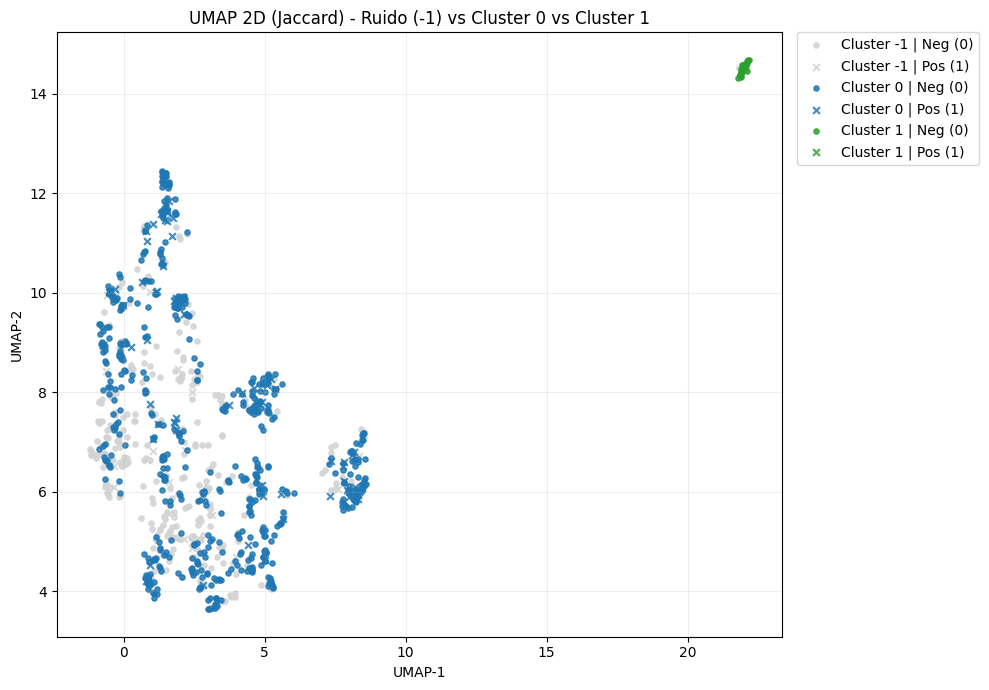

,cluster_dbscan,n_viviendas,n_positivas,tasa_positivas,n_negativas
0,-1,335,25,7.46,310
1,0,628,75,11.94,553
2,1,37,1,2.7,36


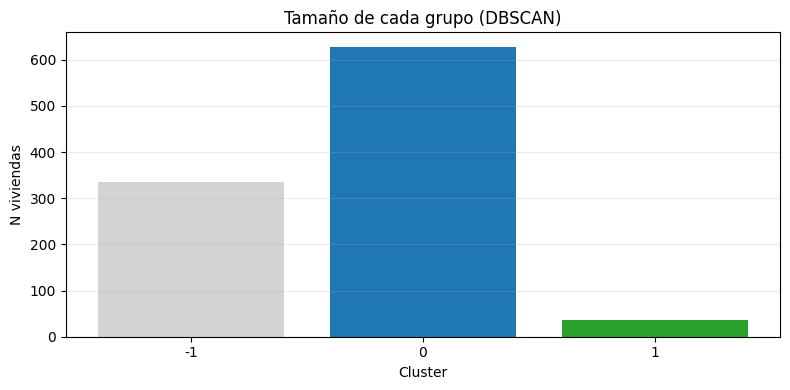

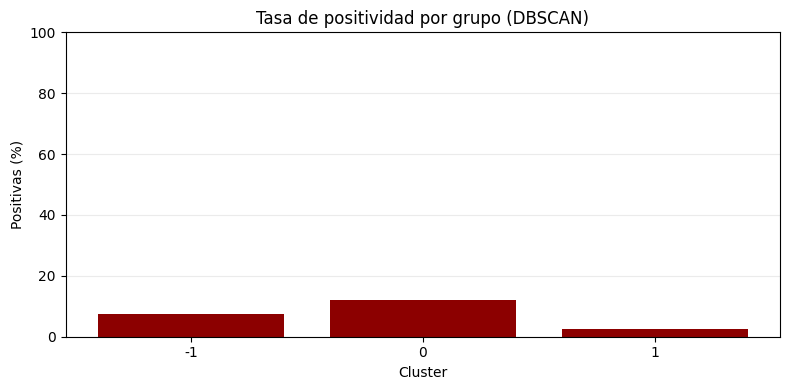

In [53]:
CLUSTER_COL = "cluster_dbscan"
STATUS_COL  = "status_entomologico"

# Status en binario
def add_status_bin(df: pd.DataFrame, status_col: str = STATUS_COL) -> pd.DataFrame:
    status_map = {
        "positiva": 1, "positivo": 1,
        "negativa": 0, "negativo": 0
    }
    y_bin = (
        df[status_col].astype(str)
          .str.strip().str.lower()
          .map(status_map)
    )
    y_num = pd.to_numeric(df[status_col], errors="coerce")
    y_final = y_bin.fillna(y_num).astype("Int64")

    out = df.copy()
    out["status_bin"] = y_final
    return out

# UMAP 2D con Jaccard
def compute_umap_2d(X_bin: pd.DataFrame,
                    n_neighbors: int = 15,
                    min_dist: float = 0.10,
                    random_state: int = 42) -> np.ndarray:
    # UMAP con Jaccard
    X_bool = X_bin.astype(bool)

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        metric="jaccard",
        random_state=random_state
    )
    emb = reducer.fit_transform(X_bool)
    return emb

# Scatter

def plot_umap_clusters(df: pd.DataFrame,
                       x_col="umap_x", y_col="umap_y",
                       cluster_col: str = CLUSTER_COL,
                       status_bin_col: str = "status_bin",
                       focus_clusters=(-1, 0, 1),
                       title="UMAP 2D (Jaccard) - DBSCAN: ruido vs clusters",
                       s=14,
                       alpha=0.85):
    dfp = df.copy()

    # Ruido + clusters de interés
    if focus_clusters is not None:
        dfp = dfp[dfp[cluster_col].isin(focus_clusters)].copy()

    color_map = {-1: "lightgray", 0: "tab:blue", 1: "tab:green"}
    default_color = "tab:red"

    plt.figure(figsize=(10, 7))


    if status_bin_col in dfp.columns and dfp[status_bin_col].notna().any():
        # negativos (0) círculo, positivos (1) X
        for g in sorted(dfp[cluster_col].unique()):
            c = color_map.get(g, default_color)

            m0 = (dfp[cluster_col] == g) & (dfp[status_bin_col] == 0)
            m1 = (dfp[cluster_col] == g) & (dfp[status_bin_col] == 1)
            mNA = (dfp[cluster_col] == g) & (dfp[status_bin_col].isna())

            if m0.any():
                plt.scatter(dfp.loc[m0, x_col], dfp.loc[m0, y_col],
                            s=s, alpha=alpha, c=c, marker="o",
                            label=f"Cluster {g} | Neg (0)")
            if m1.any():
                plt.scatter(dfp.loc[m1, x_col], dfp.loc[m1, y_col],
                            s=s+10, alpha=alpha, c=c, marker="x",
                            label=f"Cluster {g} | Pos (1)")
            if mNA.any():
                plt.scatter(dfp.loc[mNA, x_col], dfp.loc[mNA, y_col],
                            s=s, alpha=alpha, c=c, marker="^",
                            label=f"Cluster {g} | NA")
    else:
        # Solo color por cluster
        for g in sorted(dfp[cluster_col].unique()):
            c = color_map.get(g, default_color)
            m = (dfp[cluster_col] == g)
            plt.scatter(dfp.loc[m, x_col], dfp.loc[m, y_col],
                        s=s, alpha=alpha, c=c, label=f"Cluster {g}")

    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(alpha=0.2)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.show()

# Tabla cluster vs status_bin

def cluster_status_table(df: pd.DataFrame,
                         cluster_col: str = CLUSTER_COL,
                         status_bin_col: str = "status_bin") -> pd.DataFrame:
    tmp = df.dropna(subset=[status_bin_col]).copy()
    tabla = (
        tmp.groupby(cluster_col)[status_bin_col]
           .agg(n_viviendas="size", n_positivas="sum", tasa_positivas="mean")
           .reset_index()
    )
    tabla["n_negativas"] = tabla["n_viviendas"] - tabla["n_positivas"]
    tabla["tasa_positivas"] = (tabla["tasa_positivas"] * 100).round(2)
    return tabla.sort_values(cluster_col)


def plot_cluster_summary(tabla: pd.DataFrame, cluster_col: str = CLUSTER_COL):
    # Colores con el scatter
    color_map = {-1: "lightgray", 0: "tab:blue", 1: "tab:green"}
    colors_b = [color_map.get(int(c), "tab:red") for c in tabla[cluster_col].astype(int).tolist()]

    # Figura 1
    plt.figure(figsize=(8, 4))
    plt.bar(tabla[cluster_col].astype(str), tabla["n_viviendas"], color = colors_b)
    plt.title("Tamaño de cada grupo (DBSCAN)")
    plt.xlabel("Cluster")
    plt.ylabel("N viviendas")
    plt.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Figura 2 tasa de positivos por cluster
    plt.figure(figsize=(8, 4))
    plt.bar(tabla[cluster_col].astype(str), tabla["tasa_positivas"], color=colors[1])
    plt.title("Tasa de positividad por grupo (DBSCAN)")
    plt.xlabel("Cluster")
    plt.ylabel("Positivas (%)")
    plt.ylim(0, 100)
    plt.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

# Pipeline completo

def run_visualization_pipeline(df_result: pd.DataFrame,
                               X_jaccard: pd.DataFrame,
                               kept_cols: list,
                               focus_clusters=(-1, 0, 1),
                               umap_neighbors=15,
                               umap_min_dist=0.10,
                               random_state=42):
    # Alinear
    assert len(df_result) == len(X_jaccard), "df_result y X_jaccard deben tener mismas filas"
    assert (df_result.index == X_jaccard.index).all(), "df_result y X_jaccard deben tener el mismo índice/orden"

    dfv = add_status_bin(df_result, STATUS_COL)

    # UMAP sobre las features usadas en clustering
    X_use = X_jaccard[kept_cols]
    emb = compute_umap_2d(X_use, n_neighbors=umap_neighbors, min_dist=umap_min_dist, random_state=random_state)

    dfv = dfv.copy()
    dfv["umap_x"] = emb[:, 0]
    dfv["umap_y"] = emb[:, 1]

    # Scatter UMAP
    plot_umap_clusters(
        dfv, x_col="umap_x", y_col="umap_y",
        cluster_col=CLUSTER_COL, status_bin_col="status_bin",
        focus_clusters=focus_clusters,
        title="UMAP 2D (Jaccard) - Ruido (-1) vs Cluster 0 vs Cluster 1"
    )

    # Tabla + barras
    tabla = cluster_status_table(dfv, CLUSTER_COL, "status_bin")
    display(tabla)
    plot_cluster_summary(tabla, CLUSTER_COL)

    return dfv, tabla



# Visualización

df_umap, tabla_cluster = run_visualization_pipeline(
    df_result=df_result,
    X_jaccard=X_jaccard,
    kept_cols=kept_cols,
    focus_clusters=(-1, 0, 1),  # ruido, cluster 0 y 1
    umap_neighbors=15,
    umap_min_dist=0.10,
    random_state=42
)


---
## <font color='264CC7'> Conclusiones </font>

#### <font color='022257'> Conclusiones luego de realizar clustering con DBSCAN (Jaccarad) </font>

El análisis mostró una positividad global del 10.1% y evidenció perfiles de riesgo diferenciados mediante DBSCAN. El cluster 0 presentó la mayor positividad (11.94%) y se asoció a viviendas tradicionales y vulnerables (adobe/tapia, piso de tierra, teja), presencia de animales y entorno agro-rural con menor saneamiento; la concentración de positivos en UMAP respalda este patrón. El cluster 1 fue pequeño y de baja positividad (2.7%), ligado a viviendas más consolidadas, con mejores materiales y menor presencia de animales, funcionando como perfil protector. El ruido mostró un perfil mixto con riesgo intermedio (7.46%). En conjunto, el riesgo se explica por la combinación de factores estructurales y ambientales.

---
## <font color='264CC7'> Conclusiones Finales </font>

Las características de mayor relevancia para considerar una vivienda como de alto riesgo frente al Chagas, y que deben guiar la definición de estrategias de intervención, son las siguientes:

En primer lugar, las condiciones estructurales de la vivienda. La **presencia de paredes de adobe o tapia, pisos de tierra y techos de teja o materiales rústicos** genera grietas y superficies porosas que funcionan como refugio natural para el vector. Estas características son un factor crítico y consistente en los perfiles de mayor riesgo identificados.

En segundo lugar, el entorno peridomiciliario. La **presencia de animales domésticos y de corral, como perros, gatos y especialmente gallineros**, incrementa la disponibilidad de fuentes de alimento para el vector y favorece su permanencia y reproducción cerca de la vivienda. Este factor actúa como un amplificador del riesgo.

En tercer lugar, el contexto agro-rural. Viviendas asociadas a **actividades agrícolas y almacenamiento de productos como maíz** suelen ubicarse en entornos con mayor contacto entre vivienda, animales y estructuras auxiliares, lo que aumenta la probabilidad de colonización del vector.

En cuarto lugar, las condiciones de saneamiento y acceso a servicios. La **carencia de alcantarillado formal, escusado exclusivo o agua de red pública**, así como el uso de saneamiento al aire libre, se asocia a entornos menos controlados y a mayor vulnerabilidad ambiental, contribuyendo indirectamente al riesgo.

Finalmente, la combinación de estos factores es más relevante que cualquiera por separado. Las viviendas de alto riesgo son aquellas donde coinciden vulnerabilidad estructural, presencia de animales y condiciones ambientales precarias. Esta evidencia sugiere que las estrategias deben ser integrales, priorizando mejoras estructurales, manejo del peridomicilio y fortalecimiento del saneamiento, además de las acciones clásicas de control vectorial.


---
## <font color='264CC7'> Recomendaciones para futuras invetigaciones y continuación del análisis </font>

La secuela para esta investigación es incorporar la dimensión territorial. El dataset ya contiene información por parroquias, lo que abre la puerta a identificar cuáles concentran una mayor proporción de viviendas de alto riesgo. El desafío no es solo contar casos, sino ajustar el análisis para evitar que parroquias con más viviendas aparezcan artificialmente como más riesgosas. Para ello, se propone trabajar con tasas, proporciones ajustadas y estandarización por tamaño poblacional o número de viviendas muestreadas.

Con este enfoque, sería posible mapear parroquias verdaderamente más propensas, distinguiendo riesgo estructural real de simple volumen de datos. Este paso permitiría pasar del diagnóstico al territorio.

A partir de allí, se podrían priorizar estrategias de intervención escalonadas: iniciar fumigación y mejoras estructurales en las parroquias con mayor concentración de perfiles de alto riesgo, mientras que en zonas de menor riesgo se aplicarían acciones de vigilancia, educación y control preventivo. Así, los recursos se concentran donde el impacto esperado es mayor.

Una tercera línea para la continuación es incorporar la dimensión temporal. Analizar si los perfiles de riesgo y la positividad se mantienen, aumentan o disminuyen a lo largo del tiempo permitiría evaluar la efectividad de las intervenciones y anticipar nuevos focos antes de que se consoliden.

Las respuestas abiertas relacionadas con las razones para hervir o no hervir el agua representan una oportunidad valiosa para comprender prácticas, percepciones y barreras asociadas a la calidad del agua en los hogares. Para futuros análisis, se recomienda transformar estas respuestas en categorías analíticas estandarizadas, permitiendo pasar de texto libre a información comparable y accionable.

Finalmente, una expansión clave del universo narrativo sería integrar variables ambientales externas, como clima, altitud o uso del suelo, y combinarlas con los perfiles de vivienda ya identificados. Esto permitiría construir modelos predictivos más potentes y pasar de un enfoque reactivo a uno preventivo.

#### <font color='022257'> Recomendaciones para la mejora del instrumento de encuesta </font>


Para fortalecer la calidad de la información y agilizar futuros análisis, es fundamental estandarizar el diseño de las preguntas y las opciones de respuesta del cuestionario.

Asimismo, las variables relacionadas con tiempo deben manejar una sola unidad de medida por pregunta, ya sea meses o años, pero no ambas simultáneamente. Esto reduce ambigüedades, errores de interpretación y la necesidad de transformaciones posteriores que pueden introducir sesgos.

Un punto crítico identificado es la mezcla de preguntas dicotómicas (sí/no) con preguntas de cantidad dentro del mismo ítem. Para evitar inconsistencias, se recomienda separar claramente estos conceptos en preguntas secuenciales y condicionales: solo si la respuesta es “sí” debe habilitarse la pregunta de cantidad. De esta manera se previene que se registren valores contradictorios, como declarar “no tiene anaimales” y simultáneamente reportar número de animales.

Adicionalmente, se sugiere incorporar mecanismos de control durante el levantamiento de la información, como supervisión directa o acompañamiento al encuestador, especialmente en preguntas complejas o con saltos lógicos. Esto ayudaría a reducir errores de llenado y a mejorar la consistencia interna de los datos.